# Statistical and ML Models for Wind Power Predictions - PE La Castellana

In [1]:
import sys 
print(sys.version)

3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]


El dataset que se va a trabajar corresponde al Parque Eólico La Castellana (localizado en Bahia Blanca).

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
import itertools
import random
import time

from pandas.plotting import lag_plot,autocorrelation_plot
from pandas import DataFrame, concat

pd.options.mode.copy_on_write = True 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

from pylab import rcParams
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# --------
from keras.models import Sequential,Model
from keras.layers import Input, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Attention, BatchNormalization, GlobalMaxPooling1D,Reshape
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import time
#------


#from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
from scipy.interpolate import interp1d
#from sklearn.metrics import mean_squared_error
from numpy import log

# Evaluate models
from utilsforecast.losses import mae, mse, rmse, mape, smape, mase
from utilsforecast.evaluation import evaluate

# Prophet model
from prophet import Prophet

# LightGBM model
import lightgbm as lgb




#### Carga de dataset de Históricos

In [3]:
path = 'https://raw.githubusercontent.com/guilledesimone/MMA-Tesis/refs/heads/main/Datos/ds_histo_02022019-13062024.csv'

#path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\ds_histo_02022019-13062024.csv' 

df_histo_full = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S', delimiter=';', header=0)

In [4]:
# Drop rows where EnergiaSMEC is NaN
df_histo_full.dropna(subset=['EnergiaSMEC'], inplace=True)

#### Carga de dataset de Forecast & Actual para evaluar performance

In [5]:
path = 'https://raw.githubusercontent.com/guilledesimone/MMA-Tesis/refs/heads/main/Datos/ds_fc_actual_02062024-11062024.csv'

#path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\ds_fc_actual_02062024-11062024.csv' #lote 1
#path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\ds_fc_actual_17062024-26062024.csv' #lote 2


df_fc_actual = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S', delimiter=';', header=0)

In [6]:
#El forecast de aero_disp lo estimo en base al valor medio

# Filter the subset where AerosDisp is not null
filtered_df = df_fc_actual.dropna(subset=['aeros_disp'])

# Calculate the mean of aero_disp 
mean_aeros_disp = filtered_df.tail(12)['aeros_disp'].mean()

df_fc_actual['aeros_disp'] = mean_aeros_disp.round(2)

Selección de variables relevantes

In [7]:
# Define the desired column order
main_features = ['FechaHora','EnergiaSMEC','aeros_disp','ws100_avg', 'dir100_avg', 'temp_avg','energia_fc_cammesa'] #promedio de fuentes de ecwmf y gfs
#main_features = ['FechaHora','EnergiaSMEC','aeros_disp','ws100_ecmwf', 'dir100_ecmwf', 'temp_ecmwf']

In [8]:
df_fc_actual = df_fc_actual[main_features[:-1]]

In [9]:
df_fc_actual.head()

,FechaHora,EnergiaSMEC,aeros_disp,ws100_avg,dir100_avg,temp_avg
0,2024-06-02 00:00:00,0.00,28.68,3.541762,328.027785,7.445655
1,2024-06-02 01:00:00,0.00,28.68,4.245262,321.046285,7.576655
2,2024-06-02 02:00:00,6.26,28.68,4.949262,314.064285,7.707655
3,2024-06-02 03:00:00,12.28,28.68,6.686575,284.178760,7.534029
4,2024-06-02 04:00:00,20.06,28.68,6.815575,282.671760,7.536529


#### Preparación de datos historico

In [10]:
# Get the minimum FechaHora
start_date = df_fc_actual['FechaHora'].min()

# Exclude data with FechaHora >= start_date, because this is the initial date for the forecast 
df_histo_full = df_histo_full[df_histo_full['FechaHora'] < start_date]

In [11]:
# Main the DataFrame columns
df_histo = df_histo_full[main_features[:-1]]

# Set FechaHora as Index
#df_histo.set_index('FechaHora', inplace=True)

df_histo.head()

,FechaHora,EnergiaSMEC,aeros_disp,ws100_avg,dir100_avg,temp_avg
0,2019-02-02 01:00:00,44.50,30.83,8.868427,126.395675,19.159385
1,2019-02-02 02:00:00,50.97,32.00,8.438345,130.508031,18.227713
2,2019-02-02 03:00:00,44.83,32.00,8.316949,141.396578,17.171822
3,2019-02-02 04:00:00,67.56,32.00,8.288875,146.649944,17.000357
4,2019-02-02 05:00:00,59.14,32.00,8.174949,150.170589,16.486966


#### Division en train y test

In [12]:
# Define the start date for the train and test sets
train_start_dt = df_histo['FechaHora'].min()
test_start_dt = df_histo['FechaHora'].max() - pd.Timedelta(days=365)


In [13]:
# Create train set containing only the model features
df_train = df_histo[
(df_histo['FechaHora'] >= train_start_dt)
& (df_histo['FechaHora'] < test_start_dt)].copy()

# Create test set containing only the model features
df_test = df_histo_full[df_histo_full['FechaHora'] >= test_start_dt][main_features].copy()

print('Training data shape: ', df_train.shape)
print('Test data shape: ', df_test.shape)

Training data shape:  (37966, 6)
Test data shape:  (8761, 7)


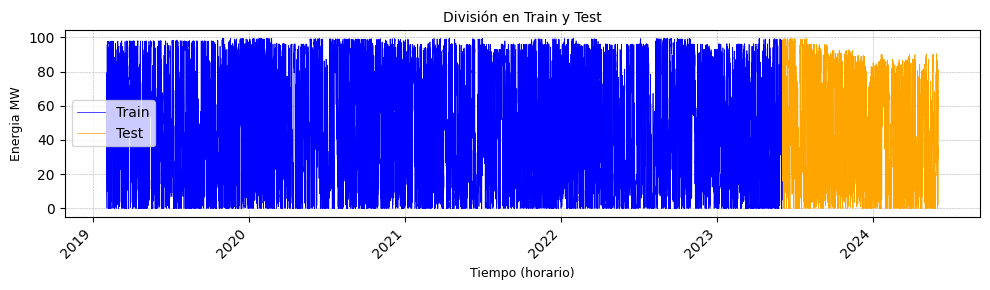

In [14]:
plt.figure(figsize=(10, 3))  # Increase figure width to 15 inches

# Plotting the data
plt.plot(df_train['FechaHora'], df_train['EnergiaSMEC'], label='Train', color='blue', linewidth=0.5)
plt.plot(df_test['FechaHora'], df_test['EnergiaSMEC'], label='Test', color='orange', linewidth=0.5)

# Adding title and labels
plt.title('División en Train y Test', fontsize=10)
plt.xlabel('Tiempo (horario)', fontsize=9)
plt.ylabel('Energia MW', fontsize=9)

# Adding legend
plt.legend(loc='best')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adding grid
plt.grid(True, linestyle='--', linewidth=0.4)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### Preparación de dataset forecast - exogenos

In [15]:
exog_features = [feature for feature in main_features if feature != 'EnergiaSMEC'and feature != 'energia_fc_cammesa']

# Reorder the DataFrame columns
df_fc_actual_exog = df_fc_actual[exog_features]
# Set FechaHora as Index
df_fc_actual_exog.set_index('FechaHora', inplace=True)

df_fc_actual_exog.head()

,aeros_disp,ws100_avg,dir100_avg,temp_avg
FechaHora,,,,
2024-06-02 00:00:00,28.68,3.541762,328.027785,7.445655
2024-06-02 01:00:00,28.68,4.245262,321.046285,7.576655
2024-06-02 02:00:00,28.68,4.949262,314.064285,7.707655
2024-06-02 03:00:00,28.68,6.686575,284.178760,7.534029
2024-06-02 04:00:00,28.68,6.815575,282.671760,7.536529


### 0. Análisis de Autorregresion

#### Grafico Autocorrelacion de la Energia generada versus valor rezagado (para el último año)

Los datos de energia eólica (t) en el eje x contra la energia eólica de la hora anterior (t-1) en el eje y.

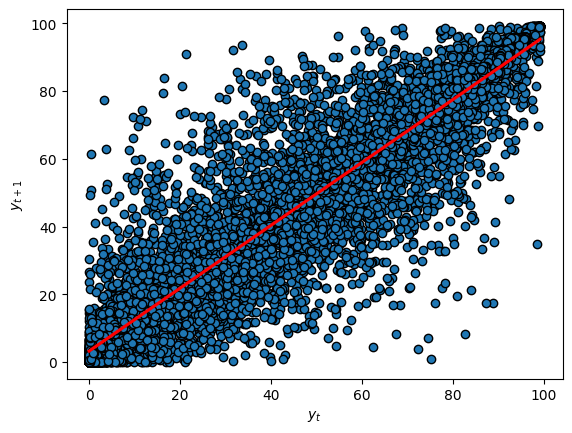

In [16]:
# Personalizar los puntos con borde más oscuro
plt.scatter(df_histo['EnergiaSMEC'].tail(8760)[:-1], df_histo['EnergiaSMEC'].tail(8760)[1:], edgecolor='black')
sns.regplot(x=df_histo['EnergiaSMEC'].tail(8760)[:-1], y=df_histo['EnergiaSMEC'].tail(8760)[1:], scatter=False, color='red')

# Agregar etiquetas a los ejes
plt.xlabel('$y_t$')
plt.ylabel('$y_{t+1}$')

plt.show()

Se puede observar gran cúmulo de valores a lo largo de una línea diagonal en el gráfico. Esto muestra claramente una relación o alguna correlación.

In [17]:
values = DataFrame(df_histo['EnergiaSMEC'])
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()

print("Correlación entre valores en t y t+1:")

result

Correlación entre valores en t y t+1:


,t,t+1
t,1.00000,0.92771
t+1,0.92771,1.00000


Muestra una fuerte correlación positiva (0.92771) entre la observación y el valor de un rezago +1.

#### Grafico de Autocorrelacion para el último año

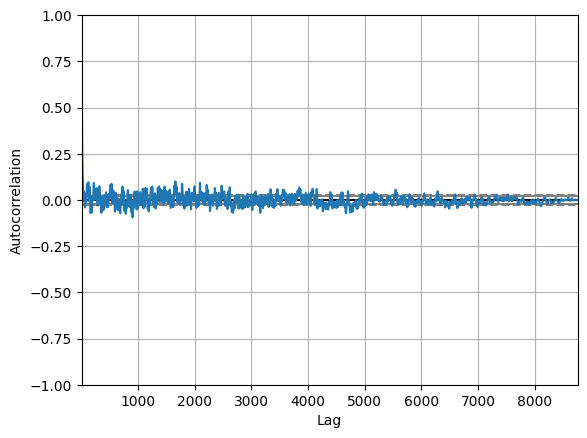

In [18]:
autocorrelation_plot(df_histo['EnergiaSMEC'].tail(8760))
plt.show()

#### ACF - Autocorrelation Function 
ACF es una función de autocorrelación que te proporciona información sobre cuánto se autocorrelaciona una serie con sus valores rezagados.

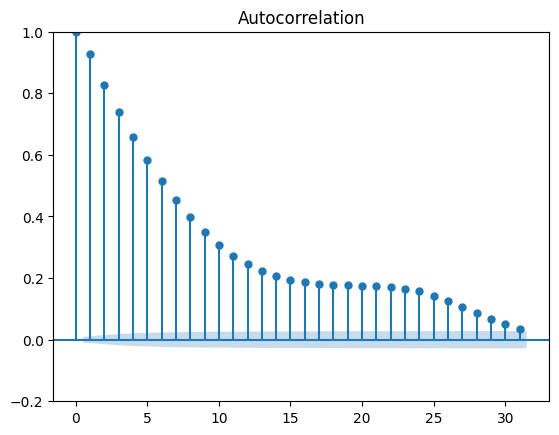

In [19]:
plot_acf(df_histo['EnergiaSMEC'], lags=31)
plt.ylim(-0.2, 1) 
plt.show()


Los intervalos de confianza se dibujan en forma de cono. Por defecto, esto está establecido en un intervalo de confianza del 95 por ciento, lo que sugiere que los valores de correlación fuera de este cono son muy probablemente una correlación. Aunque las correlaciones mas fuertes se dan cuando estan por encima de 0.5, vemos que eso se da hasta el valor rezagado t+6 

#### PACF - partial correlation function

PACF es otra función importante que, en lugar de encontrar las correlaciones entre los valores actuales y los rezagos como el ACF, encuentra la correlación de los residuos con el siguiente rezago.

En un conjunto de datos de series temporales, la autocorrelación para un valor en un instante de tiempo y otro valor en un instante de tiempo anterior consta tanto de la correlación directa entre estos dos valores como de las correlaciones indirectas. Estas correlaciones indirectas son una función lineal de la correlación del valor en observación con los valores en los instantes de tiempo intermedios.

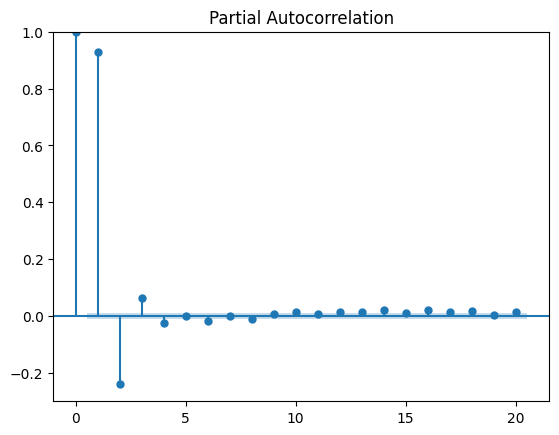

In [20]:
# Plot the pacf function on the ts_data_load dataset
plot_pacf(df_histo['EnergiaSMEC'], lags=20)
plt.ylim(-0.3, 1) 
plt.show()

Existen dos métodos que puedes utilizar para identificar el orden de un modelo AR(p):

* Las funciones ACF (Autocorrelation Function) y PACF (Partial Autocorrelation Function): Estas funciones te ayudan a identificar el orden del modelo AR(p) observando los patrones en las gráficas de autocorrelación y autocorrelación parcial.

Hasta 1 tienen una buena correlación antes de que el gráfico corte por primera vez el intervalo de confianza superior. Este es nuestro valor de 
p, el orden de nuestro proceso de autorregresión. Podemos modelar este proceso de autorregresión utilizando el primer rezago. Cuantos más rezagos incluyas en tu modelo, mejor se ajustará el modelo a los datos; sin embargo, esto también puede representar un riesgo de sobreajuste

* Los criterios de información: Como el Criterio de Información de Akaike (AIC) o el Criterio de Información de Bayes (BIC), que ayudan a seleccionar el modelo que mejor se ajusta a los datos evaluando diferentes órdenes del modelo AR(p) y comparando sus valores de criterio.

In [21]:
# Apply AutoReg model
model = AutoReg(df_histo['EnergiaSMEC'], 1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            EnergiaSMEC   No. Observations:                46727
Model:                     AutoReg(1)   Log Likelihood             -185756.707
Method:               Conditional MLE   S.D. of innovations             12.891
Date:                Thu, 14 Nov 2024   AIC                         371519.414
Time:                        17:08:01   BIC                         371545.670
Sample:                             1   HQIC                        371527.665
                                46727                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.4187      0.101     33.795      0.000       3.220       3.617
EnergiaSMEC.L1     0.9277      0.002    537.194      0.000       0.924       0.931
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0779           +0.0000j            1.0779            0.0000
-----------------------------------------------------------------------------
"""

In [22]:
# Apply covariance estimators cov_type="HC0" and output the summary
res = model.fit(cov_type="HC0")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            EnergiaSMEC   No. Observations:                46727
Model:                     AutoReg(1)   Log Likelihood             -185756.707
Method:               Conditional MLE   S.D. of innovations             12.891
Date:                Thu, 14 Nov 2024   AIC                         371519.414
Time:                        17:08:01   BIC                         371545.670
Sample:                             1   HQIC                        371527.665
                                46727                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.4187      0.086     39.583      0.000       3.249       3.588
EnergiaSMEC.L1     0.9277      0.001    704.660      0.000       0.925       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0779           +0.0000j            1.0779            0.0000
-----------------------------------------------------------------------------
"""

#### Función de prueba ADF para verificar si los datos son estacionarios.

In [23]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
    'p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [24]:
Augmented_Dickey_Fuller_Test_func(df_histo['EnergiaSMEC'],'EnergiaSMEC')

Results of Dickey-Fuller Test for column: EnergiaSMEC
Test Statistic                   -25.596998
p-value                            0.000000
No Lags Used                      50.000000
Number of Observations Used    46676.000000
Critical Value (1%)               -3.430490
Critical Value (5%)               -2.861602
Critical Value (10%)              -2.566803
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


## 1. Predicción con modelo SARIMAX

https://skforecast.org/0.9.1/user_guides/forecasting-sarimax-arima.html

#### Analisis de la serie de tiempo por hora, dia y mes

In [25]:
df_resample = df_histo.copy()

df_resample['FechaHora'] = pd.to_datetime(df_resample['FechaHora'])

df_resample.set_index('FechaHora', inplace=True)


In [26]:
df_month = df_resample.resample('MS').mean()
df_day = df_resample.resample('D').mean()


**Descomposición estacional por hora para el último año**

In [27]:
df_histo.set_index('FechaHora', inplace=True)

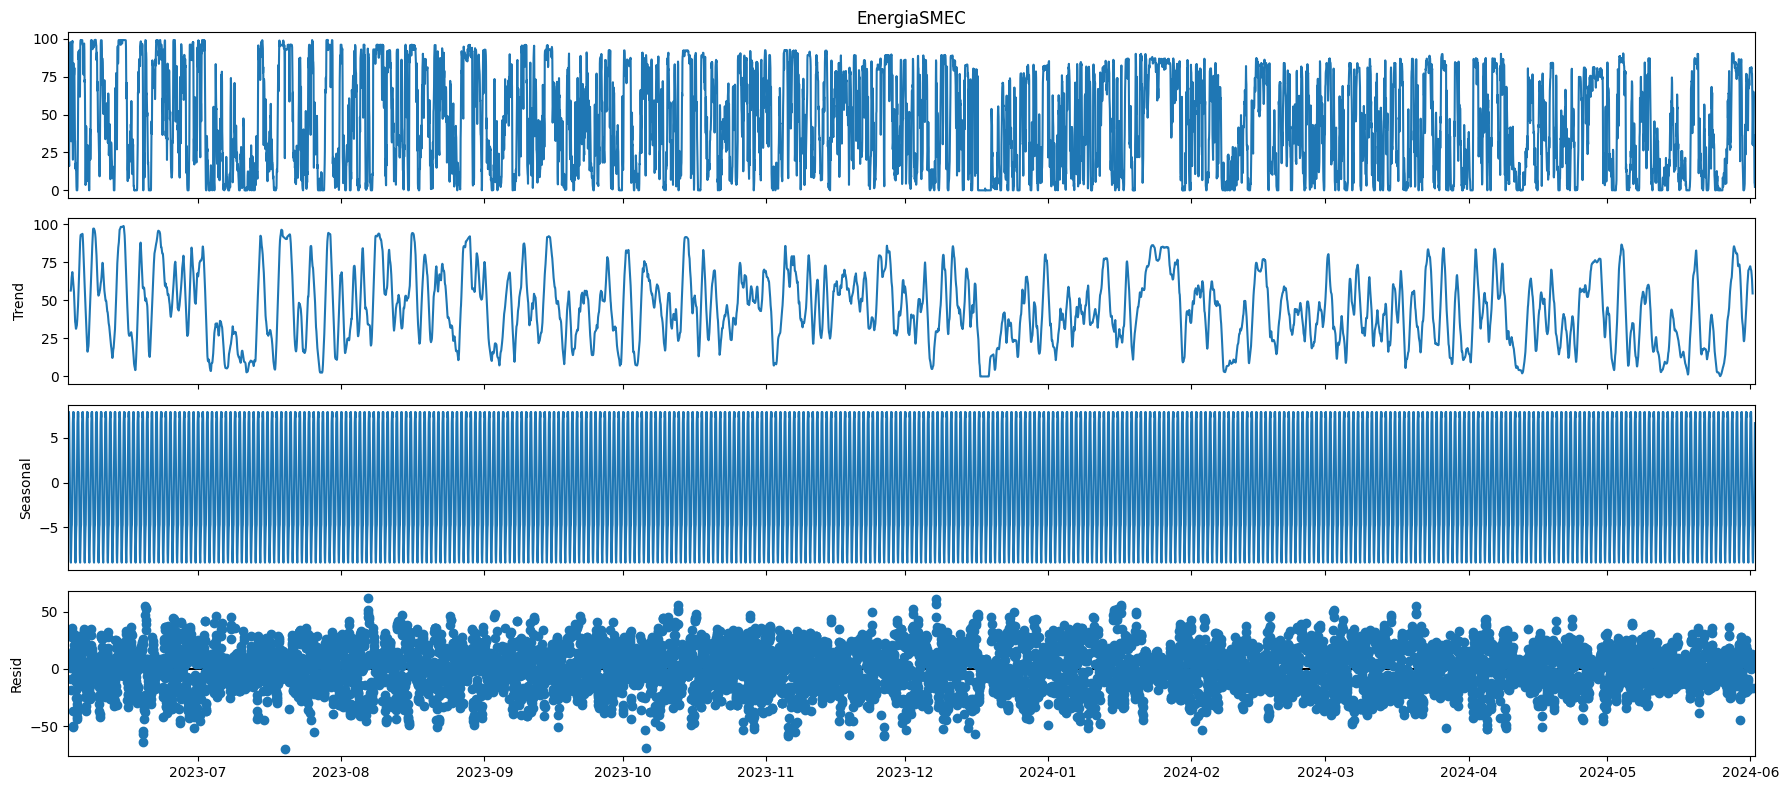

In [28]:
rcParams['figure.figsize'] = 18, 8

decomposition = seasonal_decompose(df_histo['EnergiaSMEC'].tail(8760), model='additive') #8760
fig = decomposition.plot()
plt.show()

**Descomposición estacional por dia**

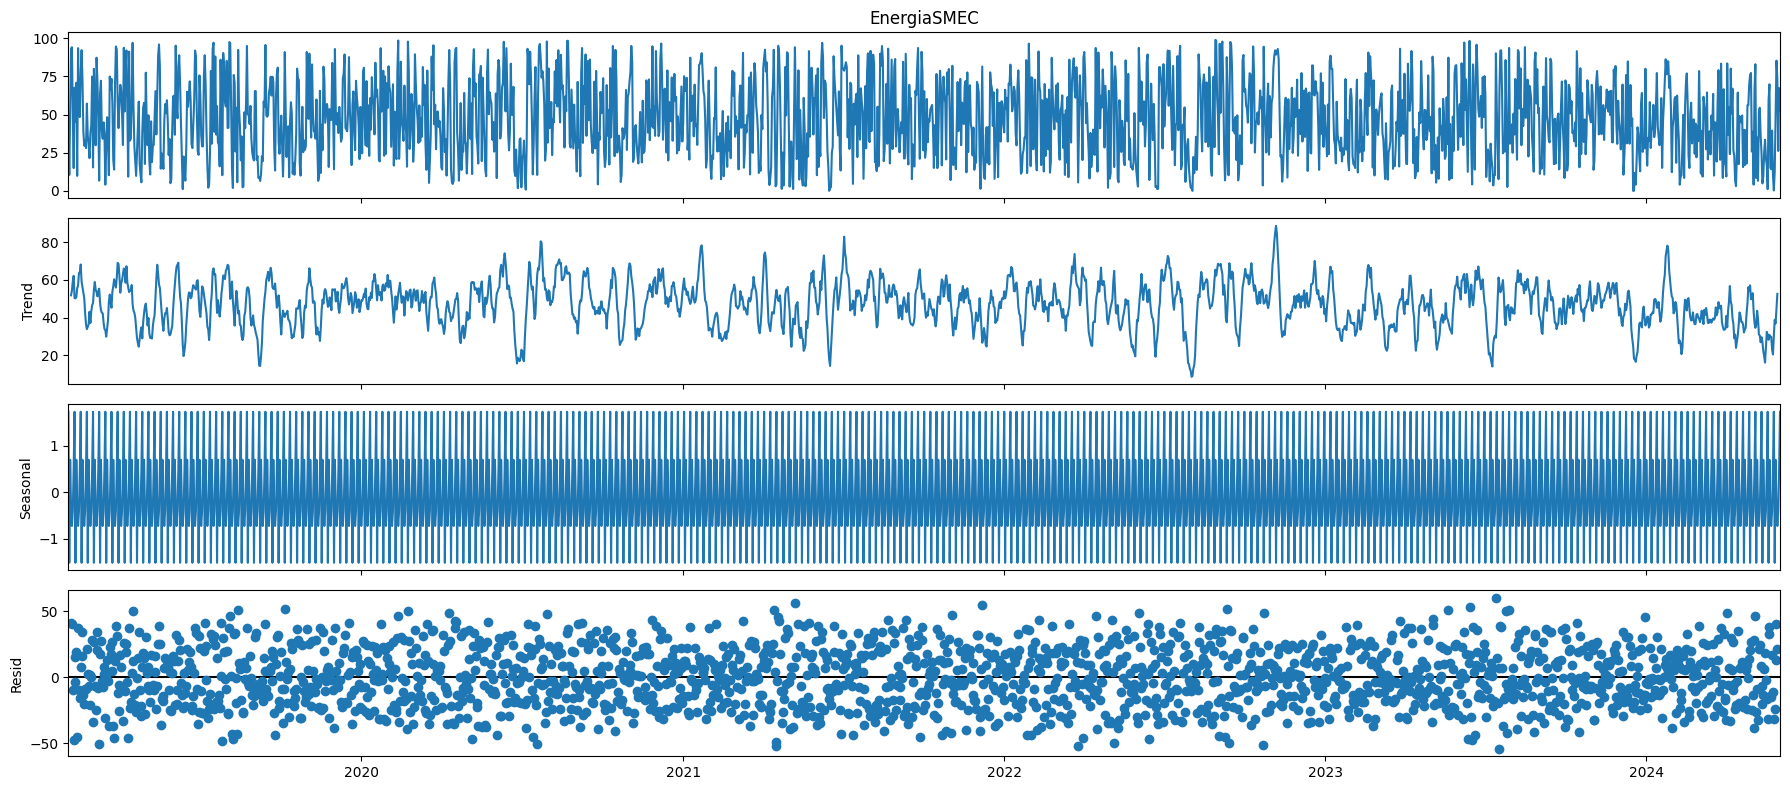

In [29]:
rcParams['figure.figsize'] = 18, 8

decomposition = seasonal_decompose(df_day['EnergiaSMEC'], model='additive')
fig = decomposition.plot()
plt.show()

**Descomposición estacional por mes**

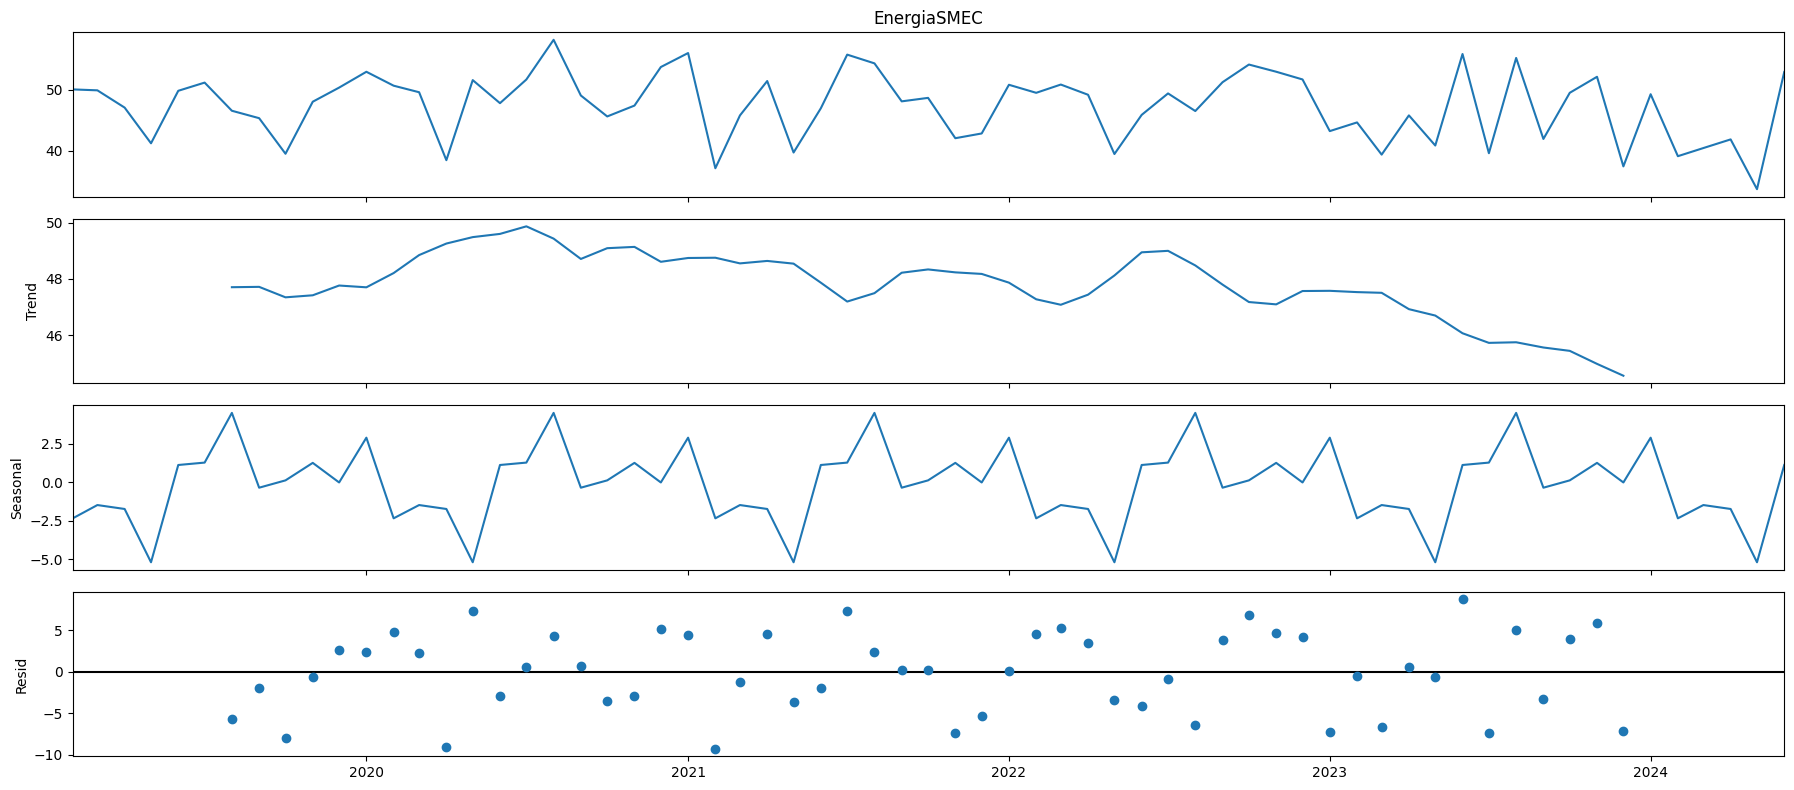

In [30]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(df_month['EnergiaSMEC'], model='additive')
fig = decomposition.plot()
plt.show()

#### Combinacción de parametros modelo SARIMAX

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [31]:
'''
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] #Hourly Data: s reflects cycles in hours.

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
'''

"\np = d = q = range(0, 2)\npdq = list(itertools.product(p, d, q))\nseasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] #Hourly Data: s reflects cycles in hours.\n\nprint('Examples of parameter combinations for Seasonal ARIMA...')\nprint('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))\nprint('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))\nprint('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))\nprint('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))\n"

#### Preparación de datos Exogenos

In [32]:
df_histo.head()

,EnergiaSMEC,aeros_disp,ws100_avg,dir100_avg,temp_avg
FechaHora,,,,,
2019-02-02 01:00:00,44.50,30.83,8.868427,126.395675,19.159385
2019-02-02 02:00:00,50.97,32.00,8.438345,130.508031,18.227713
2019-02-02 03:00:00,44.83,32.00,8.316949,141.396578,17.171822
2019-02-02 04:00:00,67.56,32.00,8.288875,146.649944,17.000357
2019-02-02 05:00:00,59.14,32.00,8.174949,150.170589,16.486966


In [33]:
df_exog = df_histo[exog_features[1:]]

_____________________________________________________________________________________________________________

### Analisis Horario

#### Grid Search to find the best SARIMAX model parameters (Se deja comentado por el tiempo que demora en correr)

In [34]:
'''
import warnings
warnings.filterwarnings("ignore")

# Convert the index to DateTimeIndex if it's not already
df_histo.index = pd.to_datetime(df_histo.index)

# Set the frequency explicitly using lowercase
df_histo = df_histo.asfreq('h')  # Use 'h' for hourly frequency

# Define your pdq and seasonal_pdq parameters
pdq = [(p, d, q) for p in range(2) for d in range(2) for q in range(2)]  
seasonal_pdq = [(P, D, Q, S) for P in range(2) for D in range(2) for Q in range(2) for S in [24]] 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df_histo['EnergiaSMEC'],
                          exog=df_exog,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=True,
                          enforce_invertibility=False)
            results = mod.fit(maxiter=50)

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as e:
            print('Exception:', e)
            continue
'''

'\nimport warnings\nwarnings.filterwarnings("ignore")\n\n# Convert the index to DateTimeIndex if it\'s not already\ndf_histo.index = pd.to_datetime(df_histo.index)\n\n# Set the frequency explicitly using lowercase\ndf_histo = df_histo.asfreq(\'h\')  # Use \'h\' for hourly frequency\n\n# Define your pdq and seasonal_pdq parameters\npdq = [(p, d, q) for p in range(2) for d in range(2) for q in range(2)]  \nseasonal_pdq = [(P, D, Q, S) for P in range(2) for D in range(2) for Q in range(2) for S in [24]] \n\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            mod = SARIMAX(df_histo[\'EnergiaSMEC\'],\n                          exog=df_exog,\n                          order=param,\n                          seasonal_order=param_seasonal,\n                          enforce_stationarity=True,\n                          enforce_invertibility=False)\n            results = mod.fit(maxiter=50)\n\n            print(\'SARIMAX{}x{} - AIC:{}\'.format(param, param_seas

SARIMAX(0, 0, 0)x(0, 0, 0, 24) - AIC:417214.1855773332
SARIMAX(0, 0, 0)x(0, 0, 1, 24) - AIC:416640.7275733506
SARIMAX(0, 0, 0)x(0, 1, 0, 24) - AIC:437343.9417441545
Exception: Unable to allocate 856. MiB for an array with shape (2289623, 49) and data type float64
SARIMAX(0, 0, 0)x(1, 0, 0, 24) - AIC:416579.8197251155
SARIMAX(0, 0, 0)x(1, 0, 1, 24) - AIC:408629.3341060929
Exception: Unable to allocate 821. MiB for an array with shape (46728, 48, 48) and data type float64
Exception: Unable to allocate 856. MiB for an array with shape (2289623, 49) and data type float64
SARIMAX(0, 0, 1)x(0, 0, 0, 24) - AIC:383829.8612804233
SARIMAX(0, 0, 1)x(0, 0, 1, 24) - AIC:383491.26204170875
SARIMAX(0, 0, 1)x(0, 1, 0, 24) - AIC:407920.03450303787
Exception: Unable to allocate 891. MiB for an array with shape (50, 50, 46727) and data type float64
SARIMAX(0, 0, 1)x(1, 0, 0, 24) - AIC:383466.50310704415
SARIMAX(0, 0, 1)x(1, 0, 1, 24) - AIC:383301.04486492765
Exception: Unable to allocate 821. MiB for an array with shape (48, 48, 46728) and data type float64
Exception: Unable to allocate 891. MiB for an array with shape (50, 50, 46727) and data type float64
SARIMAX(0, 1, 0)x(0, 0, 0, 24) - AIC:367188.7771004492
SARIMAX(0, 1, 0)x(0, 0, 1, 24) - AIC:367176.7343699094
SARIMAX(0, 1, 0)x(0, 1, 0, 24) - AIC:398426.70876188966
Exception: Unable to allocate 891. MiB for an array with shape (50, 50, 46727) and data type float64
Exception: Unable to allocate 223. MiB for an array with shape (1168175, 25) and data type float64
SARIMAX(0, 1, 0)x(1, 0, 1, 24) - AIC:367177.2424213973
SARIMAX(0, 1, 0)x(1, 1, 0, 24) - AIC:385231.84460010176
Exception: Unable to allocate 891. MiB for an array with shape (50, 50, 46727) and data type float64
SARIMAX(0, 1, 1)x(0, 0, 0, 24) - AIC:366628.92934486683
SARIMAX(0, 1, 1)x(0, 0, 1, 24) - AIC:366617.0345877009
SARIMAX(0, 1, 1)x(0, 1, 0, 24) - AIC:397888.4977961929
Exception: Unable to allocate 927. MiB for an array with shape (46728, 51, 51) and data type float64
SARIMAX(0, 1, 1)x(1, 0, 0, 24) - AIC:366616.7296359339
SARIMAX(0, 1, 1)x(1, 0, 1, 24) - AIC:366612.5196059618
Exception: Unable to allocate 856. MiB for an array with shape (2289672, 49) and data type float64
Exception: Unable to allocate 927. MiB for an array with shape (2383077, 51) and data type float64
SARIMAX(1, 0, 0)x(0, 0, 0, 24) - AIC:363699.2213444629
SARIMAX(1, 0, 0)x(0, 0, 1, 24) - AIC:363673.6491424691
SARIMAX(1, 0, 0)x(0, 1, 0, 24) - AIC:394393.7125974402
Exception: Unable to allocate 856. MiB for an array with shape (49, 49, 46728) and data type float64
SARIMAX(1, 0, 0)x(1, 0, 0, 24) - AIC:363672.9633570656
SARIMAX(1, 0, 0)x(1, 0, 1, 24) - AIC:363634.3331833541
Exception: Unable to allocate 856. MiB for an array with shape (49, 49, 46728) and data type float64
Exception: Unable to allocate 856. MiB for an array with shape (49, 49, 46728) and data type float64
SARIMAX(1, 0, 1)x(0, 0, 0, 24) - AIC:362343.14766455564
SARIMAX(1, 0, 1)x(0, 0, 1, 24) - AIC:362313.1658685091
SARIMAX(1, 0, 1)x(0, 1, 0, 24) - AIC:392908.1580584199
Exception: Unable to allocate 891. MiB for an array with shape (50, 50, 46728) and data type float64
SARIMAX(1, 0, 1)x(1, 0, 0, 24) - AIC:362312.18028013885
SARIMAX(1, 0, 1)x(1, 0, 1, 24) - AIC:362309.7007151319
Exception: Unable to allocate 856. MiB for an array with shape (49, 49, 46728) and data type float64
Exception: Unable to allocate 891. MiB for an array with shape (50, 50, 46728) and data type float64
SARIMAX(1, 1, 0)x(0, 0, 0, 24) - AIC:366806.7876284646
SARIMAX(1, 1, 0)x(0, 0, 1, 24) - AIC:366794.9694984764
SARIMAX(1, 1, 0)x(0, 1, 0, 24) - AIC:398065.3113732762
Exception: Unable to allocate 891. MiB for an array with shape (50, 50, 46728) and data type float64
SARIMAX(1, 1, 0)x(1, 0, 0, 24) - AIC:366794.65991537133
SARIMAX(1, 1, 0)x(1, 0, 1, 24) - AIC:366781.76203685213
Exception: Unable to allocate 891. MiB for an array with shape (50, 50, 46728) and data type float64
Exception: Unable to allocate 891. MiB for an array with shape (50, 50, 46727) and data type float64
SARIMAX(1, 1, 1)x(0, 0, 0, 24) - AIC:366252.7324896746
SARIMAX(1, 1, 1)x(0, 0, 1, 24) - AIC:366240.5384457033
SARIMAX(1, 1, 1)x(0, 1, 0, 24) - AIC:397487.94277387345
Exception: Unable to allocate 18.2 MiB for an array with shape (51, 46727) and data type float64
SARIMAX(1, 1, 1)x(1, 0, 0, 24) - AIC:366240.2050110559
SARIMAX(1, 1, 1)x(1, 0, 1, 24) - AIC:366240.1298771483
Exception: Unable to allocate 891. MiB for an array with shape (50, 50, 46727) and data type float64
Exception: Unable to allocate 927. MiB for an array with shape (2383077, 51) and data type float64


AIC minimo para la combinacion SARIMAX(1, 0, 1)x(1, 0, 1, 24) - AIC:362309.7007151319

#### Fitting the SARIMAX model - Hourly

In [35]:
df_histo.head()

,EnergiaSMEC,aeros_disp,ws100_avg,dir100_avg,temp_avg
FechaHora,,,,,
2019-02-02 01:00:00,44.50,30.83,8.868427,126.395675,19.159385
2019-02-02 02:00:00,50.97,32.00,8.438345,130.508031,18.227713
2019-02-02 03:00:00,44.83,32.00,8.316949,141.396578,17.171822
2019-02-02 04:00:00,67.56,32.00,8.288875,146.649944,17.000357
2019-02-02 05:00:00,59.14,32.00,8.174949,150.170589,16.486966


##### Fit train sarimax

In [36]:
df_train.set_index('FechaHora', inplace=True)

In [37]:
# Set the frequency explicitly to hourly ('H') 
df_train = df_train.asfreq('h')

In [38]:
df_train_exog = df_train[exog_features[1:]]

In [39]:
mod_hour = SARIMAX(df_train['EnergiaSMEC'], 
              exog=df_train_exog,
              order=(1, 0, 1),
              seasonal_order=(1, 0, 1, 24),
              enforce_stationarity=True,
              enforce_invertibility=False)
pred_train = mod_hour.fit(maxiter=200)
print(pred_train.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
aeros_disp     0.6077      0.013     48.434      0.000       0.583       0.632
ws100_avg      4.5880      0.055     83.357      0.000       4.480       4.696
dir100_avg     0.0020      0.001      2.227      0.026       0.000       0.004
temp_avg       0.3104      0.043      7.274      0.000       0.227       0.394
ar.L1          0.7820      0.004    181.163      0.000       0.774       0.790
ma.L1          0.2157      0.004     50.469      0.000       0.207       0.224
ar.S.L24       0.9998   9.11e-05    1.1e+04      0.000       1.000       1.000
ma.S.L24      -0.9969      0.001  -1498.536      0.000      -0.998      -0.996
sigma2       139.2761      0.777    179.288      0.000     137.754     140.799


##### Fit histo sarimax

In [40]:
df_exog = df_histo[exog_features[1:]]

In [41]:
df_histo.index.max()

Timestamp('2024-06-01 23:00:00')

In [42]:
# Set the frequency explicitly to hourly ('H') 
df_histo = df_histo.asfreq('h')
df_exog = df_exog.asfreq('h')

In [43]:
mod_hour = SARIMAX(df_histo['EnergiaSMEC'], 
              exog=df_exog,
              order=(1, 0, 1),
              seasonal_order=(1, 0, 1, 24),
              enforce_stationarity=True,
              enforce_invertibility=False)
pred_results = mod_hour.fit(maxiter=200)
print(pred_results.summary().tables[1])


C:\Users\gdesimone\AppData\Local\anaconda3\envs\tesis-python-3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
aeros_disp     0.6216      0.011     55.424      0.000       0.600       0.644
ws100_avg      4.5172      0.048     93.815      0.000       4.423       4.612
dir100_avg     0.0025      0.001      3.162      0.002       0.001       0.004
temp_avg       0.2635      0.037      7.109      0.000       0.191       0.336
ar.L1          0.7787      0.004    202.012      0.000       0.771       0.786
ma.L1          0.2162      0.004     56.324      0.000       0.209       0.224
ar.S.L24       0.9997      0.000   8020.228      0.000       0.999       1.000
ma.S.L24      -0.9959      0.001  -1576.359      0.000      -0.997      -0.995
sigma2       134.3259      0.664    202.444      0.000     133.025     135.626


## 2. Predicción con modelo Prophet

##### Fit train prophet

In [44]:
# Prepare data for Prophet
df_train_prophet = df_train.reset_index()[main_features[:-1]] 
df_train_prophet.rename(columns={'FechaHora': 'ds', 'EnergiaSMEC': 'y'}, inplace=True)

# Ensure there are no missing dates by setting frequency
df_train_prophet = df_train_prophet.set_index('ds').asfreq('h').reset_index()

In [45]:
# Initialize the Prophet model
modelpf_train = Prophet()

# Add regressors
modelpf_train.add_regressor(exog_features[1]) #aeros_disp
modelpf_train.add_regressor(exog_features[2]) #ws100
modelpf_train.add_regressor(exog_features[3]) #dir100
modelpf_train.add_regressor(exog_features[4]) #temp

# Fit the model
modelpf_train.fit(df_train_prophet)

17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing


##### Fit histo prophet

In [46]:
# Prepare data for Prophet
df_prophet = df_histo.reset_index()[main_features[:-1]] 
df_prophet.rename(columns={'FechaHora': 'ds', 'EnergiaSMEC': 'y'}, inplace=True)

# Ensure there are no missing dates by setting frequency
df_prophet = df_prophet.set_index('ds').asfreq('h').reset_index()

In [47]:
# Initialize the Prophet model
modelpf = Prophet()

# Add regressors
modelpf.add_regressor(exog_features[1]) #aeros_disp
modelpf.add_regressor(exog_features[2]) #ws100
modelpf.add_regressor(exog_features[3]) #dir100
modelpf.add_regressor(exog_features[4]) #temp

# Fit the model
modelpf.fit(df_prophet)

17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing


## 3. Predicción con modelo LightGBM

In [48]:
df_test.set_index('FechaHora', inplace=True)
#df_train.set_index('FechaHora', inplace=True)

In [49]:
# Assuming df_histo is already loaded as a DataFrame
# Split the dataset into train and test
#train, test = df_histo[:-int(len(df_histo) * 0.10)], df_histo[-int(len(df_histo) * 0.10):]

# Separate features and target
x_train, y_train = df_train.drop(columns=['EnergiaSMEC']), df_train['EnergiaSMEC'].values
x_test, y_test = df_test.drop(columns=['EnergiaSMEC','energia_fc_cammesa']), df_test['EnergiaSMEC'].values

# LightGBM parameters for initial model
params = {
    'num_leaves': 30,
    'n_estimators': 100,
    'max_depth': 8,
    'min_child_samples': 200,
    'learning_rate': 0.05,
    'subsample': 0.70,
    'colsample_bytree': 0.75
}

# Initialize the model
model = lgb.LGBMRegressor(**params)

# Parameter grid for RandomizedSearchCV
param_grid = {
    'num_leaves': [20, 30, 40, 50],
    'n_estimators': [50,70,100, 200, 400, 600],
    'max_depth': [6, 8, 10, 12],
    'min_child_samples': [20, 50, 100, 200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.5, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.75, 0.8, 0.9, 1]
}

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Set up RandomizedSearchCV with TimeSeriesSplit
random_search = RandomizedSearchCV(
    model, param_distributions=param_grid, n_iter=25, cv=tscv, verbose=1, n_jobs=-1,
    random_state=14, scoring='neg_mean_squared_error'
)

# Fit the model
random_search.fit(x_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(x_test)

# Evaluate the model
mae_t = mean_absolute_error(y_test, y_pred)
mse_t = mean_squared_error(y_test, y_pred)

rmse_t = np.sqrt(mse_t)
print(f'Best parameters found: {random_search.best_params_}')
print(f'MAE: {mae_t}')
print(f'RMSE: {rmse_t}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 37966, number of used features: 4
[LightGBM] [Info] Start training from score 47.909617
Best parameters found: {'subsample': 0.5, 'num_leaves': 30, 'n_estimators': 50, 'min_child_samples': 100, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
MAE: 10.923722234236603
RMSE: 16.194633689456477


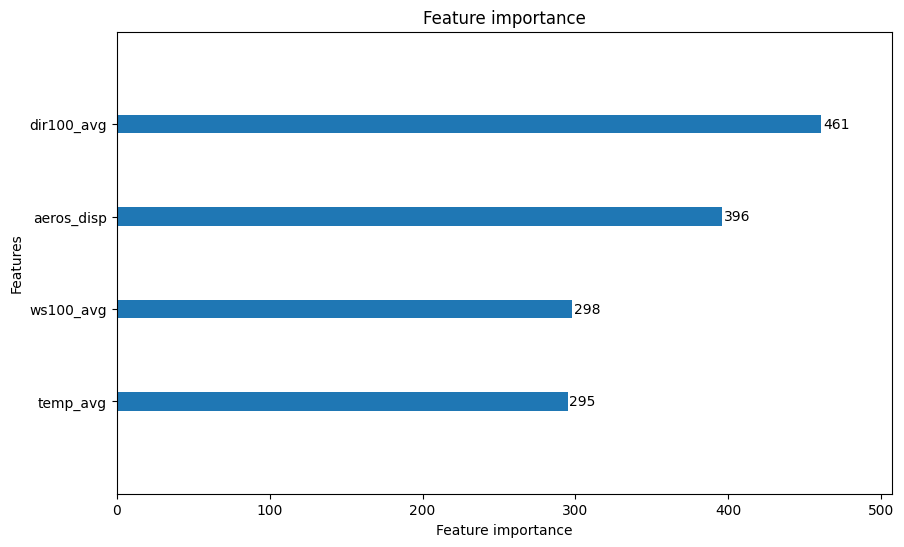

In [50]:
lgb.plot_importance(best_model, figsize=(10,6))
plt.grid(False)
plt.show()

## 4. Predicción con modelos LSTM

#### Preparación de secuencia de datos en función de timesteps

**Elección de los time_steps**  
La elección del parámetro **time_steps** depende de varios factores, incluida la naturaleza de tus datos, los patrones que esperas capturar y la complejidad de tu modelo. Al predecir la velocidad del viento, el valor apropiado de **time_steps** depende de las dependencias temporales presentes en tus datos y de cuán lejos en el futuro deseas predecir.

Aquí hay algunas consideraciones que pueden ayudar a determinar el **time_steps** apropiado para predecir la velocidad del viento:

**Patrones temporales**: Considera los patrones temporales presentes en los datos de velocidad del viento. Si la velocidad del viento presenta fluctuaciones a corto plazo o patrones horarios, un valor de **time_steps** más pequeño podría ser adecuado. Sin embargo, si la velocidad del viento cambia gradualmente durante períodos de tiempo más largos, un valor de **time_steps** más grande podría ser más apropiado.

**Estacionalidad y tendencias**: Analiza si la velocidad del viento presenta variaciones estacionales o tendencias a largo plazo. Si la velocidad del viento tiene patrones estacionales o tendencias fuertes, puede ser beneficioso incluir períodos de tiempo más largos en la secuencia de entrada para capturar estos patrones.

**Horizonte de pronóstico**: Considera el horizonte de pronóstico, es decir, cuán lejos en el futuro deseas predecir la velocidad del viento. Si estás interesado en pronósticos a corto plazo (por ejemplo, predecir la velocidad del viento para las próximas horas), pueden ser suficientes **time_steps** más cortos. Para pronósticos a largo plazo (por ejemplo, predecir la velocidad del viento para el día siguiente o la próxima semana), podrían ser necesarios **time_steps** más largos.

**Complejidad del modelo**: Los modelos más complejos pueden ser capaces de capturar dependencias a largo plazo con **time_steps** más cortos, mientras que los modelos más simples pueden requerir **time_steps** más largos para capturar información suficiente.

Dadas estas consideraciones, no hay una respuesta única para el mejor valor de **time_steps**. A menudo requiere experimentación y validación con diferentes valores para determinar la elección óptima para tu conjunto de datos específico y tarea de predicción. Puede que necesites probar diferentes valores de **time_steps** y evaluar el rendimiento de tu modelo utilizando métricas como el error cuadrático medio (MSE) o la raíz del error cuadrático medio (RMSE) en un conjunto de validación para encontrar el valor m el modelo LSTM.

**Técnica de "Windowing" o "Rolling Window" para reducir el número de muestras para cada time step**
Para reducir el número de muestras para cada time step, puedes utilizar una técnica llamada "Windowing" o "Rolling Window". Esto implica crear ventanas superpuestas o no superpuestas de muestras consecutivas de tu conjunto de datos para construir secuencias que se usarán como entrada en el modelo LSTM.

In [51]:
num_samples = df_histo.shape[0]
num_features = df_histo.shape[1] - 1  # Exclude the target variable

# Define the number of time steps and stride
time_steps = 3
stride = 1  # define el horizonte de predicción, para predicciones horarias debe ser 1. Si el time_steps = stride no hay solapamiento entre ventanas


# Initialize lists to store the sequences
X_sequences = []
y_targets = []

# Create overlapping sequences
for i in range(0, num_samples - time_steps, stride):
    # Extract the sequence of features
    sequence = df_histo.iloc[i:i + time_steps,1:]  # Input features (all columns except 'EnergiaSMEC')
    X_sequences.append(sequence)
    
    # Target variable is in the next row after the sequence
    target = df_histo.iloc[i + time_steps,0] # Target variable ('EnergiaSMEC')
    y_targets.append(target)

# Convert lists to arrays
X_sequences = np.array(X_sequences)
y_targets = np.array(y_targets)

# Reshape sequences for input into the model if needed
X_sequences = np.reshape(X_sequences, (X_sequences.shape[0], time_steps, num_features))

In [52]:
X_sequences.shape

(46724, 3, 4)

In [53]:
y_targets.shape

(46724,)

In [54]:
# Perform scaling for input features
scaler_X = MinMaxScaler()
X_sequences_scaled = scaler_X.fit_transform(X_sequences.reshape(-1, num_features)).reshape(X_sequences.shape)

# Perform scaling for target variable
scaler_y = MinMaxScaler()
y_targets_scaled = scaler_y.fit_transform(y_targets.reshape(-1, 1)).flatten()

In [55]:
# Access the parameters of the scaler
print("Min values for each feature:", scaler_X.data_min_)
print("Max values for each feature:", scaler_X.data_max_)
print("Scale of each feature:", scaler_X.scale_)
	

Min values for each feature: [ 0.00000000e+00  2.11694305e-01  2.58488424e-04 -2.37243440e+00]
Max values for each feature: [ 32.          22.65293261 359.9998205   41.38176529]
Scale of each feature: [0.03125    0.04456082 0.00277778 0.02285495]


In [56]:
# Access the parameters of the scaler
print("Min values for each feature:", scaler_y.data_min_)
print("Max values for each feature:", scaler_y.data_max_)
print("Scale of each feature:", scaler_y.scale_)

Min values for each feature: [0.]
Max values for each feature: [99.44]
Scale of each feature: [0.01005632]


In [57]:
p_test_size = df_test.shape[0]/(df_histo.shape[0]- time_steps) # Se mantiene la misma proporción de split que en los modelos anteriores que corresponde al ultimo año

##### Split en test, validation y training

Se realizan con shuffle=False para que realice una mezcla de los valores

In [58]:
# First split: divide el conjunto en entrenamiento temporario y test 
X_train_temp, X_test_scaled, y_train_temp, y_test_scaled = train_test_split(X_sequences_scaled, y_targets_scaled, test_size=p_test_size, shuffle=False)

# Second split: divide el conjunto temporario en validación y entrenamiento
X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(X_train_temp, y_train_temp, test_size=0.1, shuffle=False)

#### Definición de la arquitectura del modelo LSTM

In [59]:
'''

#5)

# Definir las variables
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
cnn_filters = 256
cnn_kernel_size = 2  # Ajustado para evitar reducción negativa de dimensión
cnn_activation = 'relu'
cnn_pool_size = 1  # Ajustado para evitar reducción negativa de dimensión
dropout_rate = 0.2
lstm_units = 256
dense_units = 1
dense_activation = 'linear'

# Definir la capa de entrada
inputs = Input(shape=input_shape)

# Capas CNN adicionales
cnn_out = Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation=cnn_activation)(inputs)
cnn_out = MaxPooling1D(pool_size=cnn_pool_size)(cnn_out)
cnn_out = Dropout(dropout_rate)(cnn_out)

# Verificación de la dimensión antes de la siguiente capa de Conv1D
if cnn_out.shape[1] >= cnn_kernel_size:
    cnn_out = Conv1D(filters=cnn_filters // 2, kernel_size=cnn_kernel_size, activation=cnn_activation)(cnn_out)
    cnn_out = MaxPooling1D(pool_size=cnn_pool_size)(cnn_out)
    cnn_out = Dropout(dropout_rate)(cnn_out)
    cnn_out = BatchNormalization()(cnn_out)

# Capas LSTM adicionales
lstm_out = LSTM(lstm_units, return_sequences=True)(cnn_out)
lstm_out = Dropout(dropout_rate)(lstm_out)

# Alinear las dimensiones de salida de cnn_out y lstm_out antes de la capa de Atención
cnn_out_aligned = Dense(lstm_units)(cnn_out)
lstm_out_aligned = Dense(lstm_units)(lstm_out)

# Capa de atención
attention = Attention()([cnn_out_aligned, lstm_out_aligned])

# Aplanar la salida
flatten_out = Flatten()(attention)

# Capas densas adicionales
dense_out = Dense(128, activation='relu')(flatten_out)
dense_out = Dropout(dropout_rate)(dense_out)

# Capa de salida
outputs = Dense(dense_units, activation=dense_activation)(dense_out)

# Definir el modelo
model_lstm = Model(inputs=inputs, outputs=outputs)

# Imprimir resumen del modelo 
model_lstm.summary()
'''

"\n\n#5)\n\n# Definir las variables\ninput_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])\ncnn_filters = 256\ncnn_kernel_size = 2  # Ajustado para evitar reducción negativa de dimensión\ncnn_activation = 'relu'\ncnn_pool_size = 1  # Ajustado para evitar reducción negativa de dimensión\ndropout_rate = 0.2\nlstm_units = 256\ndense_units = 1\ndense_activation = 'linear'\n\n# Definir la capa de entrada\ninputs = Input(shape=input_shape)\n\n# Capas CNN adicionales\ncnn_out = Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation=cnn_activation)(inputs)\ncnn_out = MaxPooling1D(pool_size=cnn_pool_size)(cnn_out)\ncnn_out = Dropout(dropout_rate)(cnn_out)\n\n# Verificación de la dimensión antes de la siguiente capa de Conv1D\nif cnn_out.shape[1] >= cnn_kernel_size:\n    cnn_out = Conv1D(filters=cnn_filters // 2, kernel_size=cnn_kernel_size, activation=cnn_activation)(cnn_out)\n    cnn_out = MaxPooling1D(pool_size=cnn_pool_size)(cnn_out)\n    cnn_out = Dropout(dropout_rat

In [60]:

# Definir las variables
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
cnn_filters = 256
cnn_kernel_size = 2
cnn_activation = 'relu'
dropout_rate = 0.2
lstm_units = 256
dense_units = 1
dense_activation = 'linear'

# Definir la capa de entrada
inputs = Input(shape=input_shape)

# Bloque CNN
cnn_out = Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation=cnn_activation, padding="same")(inputs)
cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
cnn_out = Dropout(dropout_rate)(cnn_out)

cnn_out = Conv1D(filters=cnn_filters // 2, kernel_size=cnn_kernel_size, activation=cnn_activation, padding="same")(cnn_out)
cnn_out = GlobalMaxPooling1D()(cnn_out)  # Usar GlobalMaxPooling para reducir dimensionalidad

# Bloque LSTM
lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
lstm_out = Dropout(dropout_rate)(lstm_out)

# Alinear las dimensiones de salida antes de la capa de atención
cnn_out_aligned = Dense(lstm_units)(cnn_out)  # Expandimos cnn_out para que coincida con lstm_out

# Utilizar Reshape en lugar de tf.expand_dims
cnn_out_reshaped = Reshape((1, lstm_units))(cnn_out_aligned)  # Agregamos una dimensión extra

# Capa de atención
attention_out = Attention()([cnn_out_reshaped, lstm_out])

# Aplanar la salida de la atención
attention_out = GlobalMaxPooling1D()(attention_out)  # Global pooling para evitar warnings

# Capas densas adicionales
dense_out = Dense(128, activation='relu')(attention_out)
dense_out = Dropout(dropout_rate)(dense_out)

# Capa de salida
outputs = Dense(dense_units, activation=dense_activation)(dense_out)

# Definir el modelo
model_lstm = Model(inputs=inputs, outputs=outputs)

# Imprimir resumen del modelo 
model_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 3, 4)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 3, 256)            │           2,304 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 1, 256)            │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1, 256)            │               0 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 1, 128)            │          65,664 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 128)               │               0 │ conv1d_1[0][0]             │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │          33,024 │ global_max_pooling1d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 3, 256)            │         267,264 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 256)            │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 3, 256)            │               0 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention (Attention)         │ (None, 1, 256)            │               0 │ reshape[0][0],             │
│                               │                           │                 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_1        │ (None, 256)               │               0 │ attention[0][0]            │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          32,896 │ global_max_pooling1d_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │             129 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 401,281 (1.53 MB)

 Trainable params: 401,281 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

##### Compilacion del modelo

In [61]:
model_lstm.compile(loss= 'mse',
              metrics=['mse','mae'],
              optimizer='adam')

##### Fit model

In [62]:
# Definir las variables de entrenamiento
epochs = 100
batch_size = 32
validation_split = 0.1
patience = 10
monitor_metric = 'val_loss'

# Configurar el early stopping
early_stopping = EarlyStopping(patience=patience, monitor=monitor_metric, restore_best_weights=True)

start_time = time.time()

# Entrenar el modelo
history = model_lstm.fit(
    X_train_scaled, y_train_scaled,
    epochs=epochs,
    batch_size=batch_size,
    #validation_split=validation_split,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stopping],
    verbose=1
)

end_time = time.time()

# Calcular el tiempo de entrenamiento
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

Epoch 1/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0632 - mae: 0.1987 - mse: 0.0632 - val_loss: 0.0402 - val_mae: 0.1562 - val_mse: 0.0402
Epoch 2/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0386 - mae: 0.1491 - mse: 0.0386 - val_loss: 0.0353 - val_mae: 0.1480 - val_mse: 0.0353
Epoch 3/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0361 - mae: 0.1424 - mse: 0.0361 - val_loss: 0.0339 - val_mae: 0.1366 - val_mse: 0.0339
Epoch 4/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0357 - mae: 0.1405 - mse: 0.0357 - val_loss: 0.0358 - val_mae: 0.1413 - val_mse: 0.0358
Epoch 5/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0348 - mae: 0.1385 - mse: 0.0348 - val_loss: 0.0338 - val_mae: 0.1391 - val_mse: 0.0338
Epoch 6/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0350 - mae: 0.1388 - mse: 0.0350 - val_loss: 0.0396 - val_mae: 0.1466 - val_mse: 0.0396
Epoch 7/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0338 - mae: 0.

In [63]:
# Evaluate the model
loss = model_lstm.evaluate(X_test_scaled, y_test_scaled)
#print("Test Loss:", loss)

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0309 - mae: 0.1226 - mse: 0.0309


In [64]:
# Make predictions
predictions = model_lstm.predict(X_test_scaled)

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


#### Evaluación del modelo Training and Validation Loss


Al examinar las curvas, puedes obtener información sobre la dinámica de aprendizaje del modelo:

**Escenario ideal:** En un escenario ideal, tanto la pérdida de entrenamiento como la pérdida de validación deberían disminuir de manera constante con cada época, lo que indica que el modelo está aprendiendo de manera efectiva sin sobreajustarse.

**Sobreajuste:** Si la pérdida de entrenamiento disminuye mientras que la pérdida de validación comienza a aumentar o se mantiene alta, esto indica sobreajuste. Es posible que observes una brecha significativa entre las curvas de pérdida de entrenamiento y validación.

**Subajuste:** Si tanto la pérdida de entrenamiento como la pérdida de validación permanecen altas y no disminuyen significativamente, esto indica subajuste. En este caso, el modelo puede no tener suficiente capacidad para capturar los patrones subyacentes en los datos.

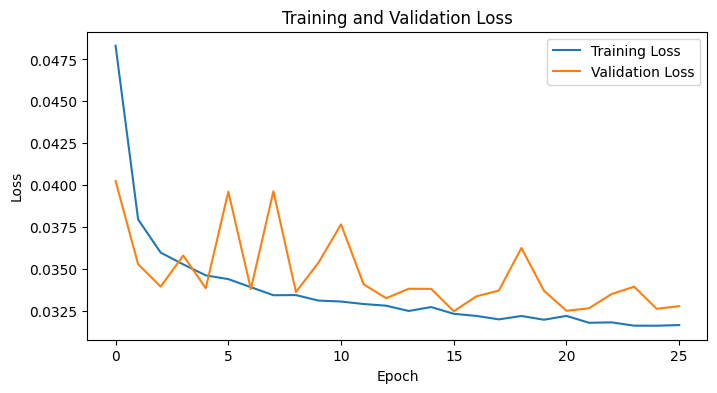

In [65]:
# Plot training and validation loss curves
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
# Perform inverse scaling on predictions
predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Perform inverse scaling on predictions
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

### 4. Evaluación de pronósticos de generacion de Energia en dataset de TEST (último año)

#### Predicción de Energia en dataset de TEST (último año) con SARIMAX

In [67]:
if df_test.index.name != 'FechaHora':
    df_test.set_index('FechaHora', inplace=True)

In [68]:
# Get the minimum and maximum FechaHora
start_test_date = df_test.index.min()
end_test_date = df_test.index.max()
print(f"Start date: {start_test_date} | End date: {end_test_date}")

Start date: 2023-06-02 23:00:00 | End date: 2024-06-01 23:00:00


In [69]:
df_test_exog = df_test[exog_features[1:]]


In [70]:
# Set the frequency explicitly to hourly ('H') 
df_test_exog = df_test_exog.asfreq('h')

In [71]:
# Get predictions
pred_test_df = pred_train.get_prediction(start=start_test_date, end=end_test_date, exog=df_test_exog, dynamic=False)

# Extract the predicted mean and confidence intervals
predicted_test_mean = pred_test_df.predicted_mean
pred_test_ci = pred_test_df.conf_int()


In [72]:
# Create a TEST DataFrame with predicted values
df_pred_test_energia_sarimax = pd.DataFrame({
    'FechaHora': predicted_test_mean.index,
    'pred_energia_sarimax': predicted_test_mean.values,
    'Lower_CI': pred_test_ci.iloc[:, 0].values,
    'Upper_CI': pred_test_ci.iloc[:, 1].values
})

In [73]:
df_pred_test_energia_sarimax.head()

,FechaHora,pred_energia_sarimax,Lower_CI,Upper_CI
0,2023-06-02 23:00:00,21.004135,-2.126445,44.134714
1,2023-06-03 00:00:00,28.902460,-3.771968,61.576887
2,2023-06-03 01:00:00,34.144680,-3.182478,71.471837
3,2023-06-03 02:00:00,37.240178,-2.665858,77.146213
4,2023-06-03 03:00:00,38.242981,-3.161047,79.647009


#### Predicción de Energia en dataset de TEST (último año) con Prophet

In [74]:
# Sample forecast exogenous data (ensure this is your actual forecast exogenous data)
df_prophet_test = df_test_exog.reset_index()

df_prophet_test.rename(columns={'FechaHora': 'ds'}, inplace=True)

# Make predictions
forecast_test = modelpf.predict(df_prophet_test)

# Display forecast
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

                      ds       yhat  yhat_lower  yhat_upper
8756 2024-06-01 19:00:00  36.137209   13.137412   58.709031
8757 2024-06-01 20:00:00  42.012420   19.803514   64.363205
8758 2024-06-01 21:00:00  24.502578    0.935872   49.802577
8759 2024-06-01 22:00:00  20.849444   -4.122531   46.036519
8760 2024-06-01 23:00:00  21.306532   -1.262777   47.070772


In [75]:
df_pred_test_energia_prophet = forecast_test[['ds','yhat','yhat_lower','yhat_upper']]

In [76]:
# Rename columns
df_pred_test_energia_prophet.rename(columns={
    'ds': 'FechaHora',
    'yhat': 'pred_energia_prophet',
    'yhat_lower': 'Lower_CI',
    'yhat_upper': 'Upper_CI'
}, inplace=True)

In [77]:
df_pred_test_energia_prophet.head()

,FechaHora,pred_energia_prophet,Lower_CI,Upper_CI
0,2023-06-02 23:00:00,27.732939,2.167428,51.329780
1,2023-06-03 00:00:00,33.636082,9.551590,58.785244
2,2023-06-03 01:00:00,38.566976,14.322012,61.313831
3,2023-06-03 02:00:00,40.224227,16.260803,65.408545
4,2023-06-03 03:00:00,40.241601,15.405761,63.367644


#### Predicción de Energia en dataset de TEST (último año) con LightGBM

In [78]:
# Predict on test data
pred_test_energia_lgb = best_model.predict(df_test_exog)

In [79]:
# Create a DataFrame with the predictions
df_pred_test_energia_lgb = pd.DataFrame({
    'FechaHora': df_test_exog.index,
    'pred_energia_lgb': pred_test_energia_lgb
})

In [80]:
df_pred_test_energia_lgb.head()

,FechaHora,pred_energia_lgb
0,2023-06-02 23:00:00,15.681673
1,2023-06-03 00:00:00,18.151282
2,2023-06-03 01:00:00,28.366471
3,2023-06-03 02:00:00,24.321430
4,2023-06-03 03:00:00,33.980329


#### Predicción de Energia en dataset de TEST (último año) con LSTM

In [81]:
# Combine into DataFrame
df_pred_test_energia_lstm = pd.DataFrame({
    'FechaHora': df_test_exog.index,
    'pred_energia_lstm': predictions_original,
})

In [82]:
df_pred_test_energia_lstm.head()

,FechaHora,pred_energia_lstm
0,2023-06-02 23:00:00,13.228371
1,2023-06-03 00:00:00,17.601803
2,2023-06-03 01:00:00,26.689203
3,2023-06-03 02:00:00,32.866417
4,2023-06-03 03:00:00,31.606894


##### Merge de dataframes pred test

In [83]:
df_test.reset_index(inplace=True)

In [84]:
# Convert 'FechaHora' to datetime format
df_test['FechaHora'] = pd.to_datetime(df_test['FechaHora'])
df_pred_test_energia_sarimax['FechaHora'] = pd.to_datetime(df_pred_test_energia_sarimax['FechaHora'])
df_pred_test_energia_prophet['FechaHora'] = pd.to_datetime(df_pred_test_energia_prophet['FechaHora'])
df_pred_test_energia_lgb['FechaHora'] = pd.to_datetime(df_pred_test_energia_lgb['FechaHora'])
df_pred_test_energia_lstm['FechaHora'] = pd.to_datetime(df_pred_test_energia_lstm['FechaHora'])

In [85]:
# Merge df_pred_test_energia_sarimax
df_fc_test = df_test.merge(df_pred_test_energia_sarimax[['FechaHora','pred_energia_sarimax']], on='FechaHora', how='left')

In [86]:
# Merge df_pred_test_energia_prophet
df_fc_test = df_fc_test.merge(df_pred_test_energia_prophet[['FechaHora','pred_energia_prophet']], on='FechaHora', how='left')

In [87]:
# Merge df_pred_test_energia_lgb
df_fc_test = df_fc_test.merge(df_pred_test_energia_lgb[['FechaHora','pred_energia_lgb']], on='FechaHora', how='left')

In [88]:
# Merge df_pred_test_energia_lstm
df_fc_test = df_fc_test.merge(df_pred_test_energia_lstm[['FechaHora','pred_energia_lstm']], on='FechaHora', how='left')

In [89]:
df_fc_test.head()

,FechaHora,EnergiaSMEC,aeros_disp,ws100_avg,dir100_avg,temp_avg,energia_fc_cammesa,pred_energia_sarimax,pred_energia_prophet,pred_energia_lgb,pred_energia_lstm
0,2023-06-02 23:00:00,34.24,31.50,4.240309,277.424611,10.332597,18.77,21.004135,27.732939,15.681673,13.228371
1,2023-06-03 00:00:00,41.84,31.67,4.949494,289.320371,9.690147,33.41,28.902460,33.636082,18.151282,17.601803
2,2023-06-03 01:00:00,38.10,31.00,5.623581,288.221038,9.570891,40.37,34.144680,38.566976,28.366471,26.689203
3,2023-06-03 02:00:00,41.80,31.33,5.782163,286.562365,9.365487,38.90,37.240178,40.224227,24.321430,32.866417
4,2023-06-03 03:00:00,20.36,32.00,5.755507,302.932115,8.004326,43.21,38.242981,40.241601,33.980329,31.606894


#### Evaluación de metricas de performance en dataset de TEST (último año) 

In [90]:
#Rename de columnas
df_fc_test.rename(columns={
    'energia_fc_cammesa':'pred_energia_cammesa'
}, inplace=True)

In [91]:
# Add a dummy 'unique_id' column to the DataFrame
df_fc_test['unique_id'] = 1

In [92]:
# Evaluate models
results_test = evaluate(
    df=df_fc_test,
    metrics=[mae, rmse, mape, smape],  
    models=['pred_energia_sarimax','pred_energia_prophet','pred_energia_lgb','pred_energia_lstm','pred_energia_cammesa'],  # Pronosticos de las diferente fuentes
    target_col='EnergiaSMEC'  # Energia Generada en el parque Eólico
)

# Output the results
results_test.head()

,unique_id,metric,pred_energia_sarimax,pred_energia_prophet,pred_energia_lgb,pred_energia_lstm,pred_energia_cammesa
0,1,mae,17.271232,14.066233,10.923722,11.827321,12.221103
1,1,rmse,20.298261,17.595662,16.194634,16.804879,16.634552
2,1,mape,5.276436,3.809232,0.857441,2.750772,3.657225
3,1,smape,0.310627,0.275566,0.242309,0.254389,0.238397


In [93]:
# Transpose the DataFrame
df_results_test = results_test.melt(id_vars=['unique_id', 'metric'], 
                  value_vars=['pred_energia_sarimax','pred_energia_prophet','pred_energia_lgb','pred_energia_lstm','pred_energia_cammesa'], 
                  var_name='model', 
                  value_name='value')

# Drop the 'unique_id' column as it's not needed for plotting
df_results_test = df_results_test.drop(columns=['unique_id'])

df_results_test['value']=df_results_test['value'].round(2)
#df_results.head(10)

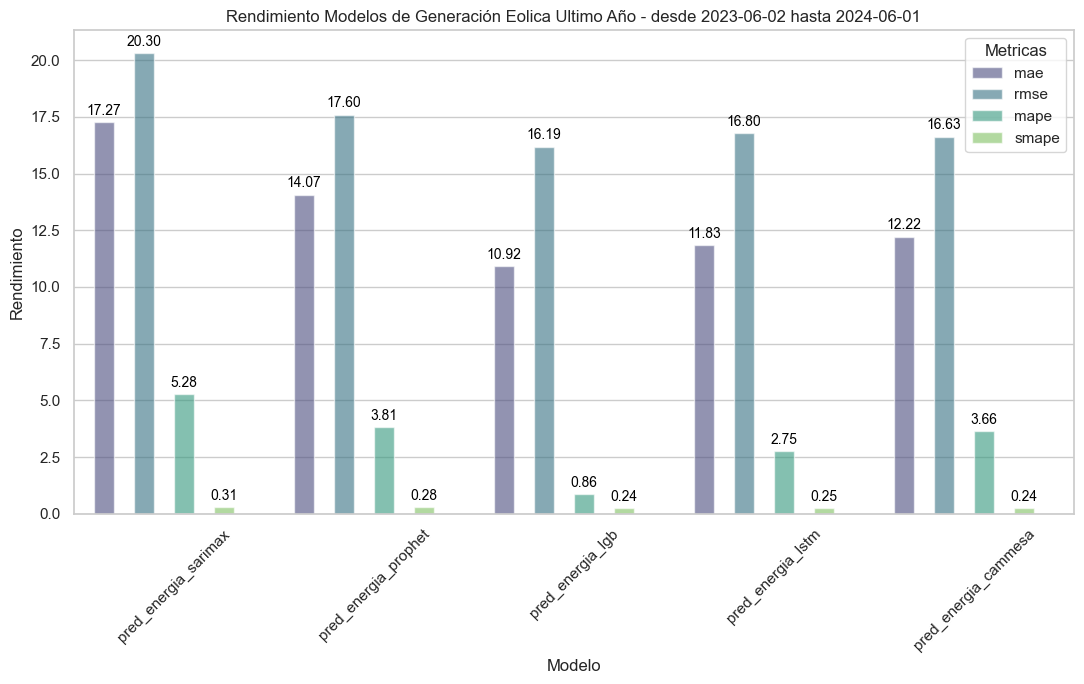

In [94]:
# Function to create barplot
def plot_performance(data, title, xlabel, ylabel):
    sns.set_theme(style="whitegrid")

    # Create a figure
    plt.figure(figsize=(11, 7))  # Width x Height

    # Draw a nested barplot
    g = sns.barplot(
        data=data,
        x="model", y="value", hue="metric",
        palette="viridis", alpha=.6
    )

    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)

    # Adjust legend
    plt.legend(title="Metricas")

    # Adjust the bar width
    bar_width = 0.1  # Set the desired bar width

    # Annotate each bar
    for bar in g.patches:
        bar.set_width(bar_width)
        height = bar.get_height()
        if height > 0.01:  # Skip very small values to avoid clutter
            g.annotate(f'{height:.2f}', 
                       (bar.get_x() + bar.get_width() / 2, height),
                       ha='center', va='bottom',
                       fontsize=10, color='black', xytext=(0, 3),
                       textcoords='offset points')

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
    plt.show()

# Create the dynamic legend text
title = f"Rendimiento Modelos de Generación Eolica Ultimo Año - desde {start_test_date.date()} hasta {end_test_date.date()}"

# Plot for df_results_test
plot_performance(df_results_test, title, "Modelo", "Rendimiento")


### 5. Evaluación de pronósticos de generacion de Energia a 10 dias

In [95]:
df_fc_actual_exog.reset_index(inplace=True)

In [96]:
# Get the minimum and maximum FechaHora
start_date_10d = df_fc_actual_exog['FechaHora'].min()
end_date_10d = df_fc_actual_exog['FechaHora'].max()
print(f"Start date: {start_date_10d} | End date: {end_date_10d}")

Start date: 2024-06-02 00:00:00 | End date: 2024-06-11 21:00:00


In [97]:
df_fc_actual_exog['FechaHora'] = pd.to_datetime(df_fc_actual_exog['FechaHora'])
df_fc_actual_exog.set_index('FechaHora', inplace=True)

#### Predicción de Energia a 10 dias con SARIMAX

In [98]:
# Calculate the min and max values from historical data
min_value = df_histo['EnergiaSMEC'].min()
max_value = df_histo['EnergiaSMEC'].max()

In [99]:
df_fc_actual_exog.head()

,aeros_disp,ws100_avg,dir100_avg,temp_avg
FechaHora,,,,
2024-06-02 00:00:00,28.68,3.541762,328.027785,7.445655
2024-06-02 01:00:00,28.68,4.245262,321.046285,7.576655
2024-06-02 02:00:00,28.68,4.949262,314.064285,7.707655
2024-06-02 03:00:00,28.68,6.686575,284.178760,7.534029
2024-06-02 04:00:00,28.68,6.815575,282.671760,7.536529


In [101]:
# Get predictions
pred_df = pred_results.get_prediction(start=start_date_10d, end=end_date_10d, exog=df_fc_actual_exog, dynamic=False)

# Extract the predicted mean and confidence intervals
predicted_mean = pred_df.predicted_mean
pred_ci = pred_df.conf_int()

# Clamp predicted values within min and max of historical data
predicted_mean = predicted_mean.clip(lower=min_value, upper=max_value)
pred_ci.iloc[:, 0] = pred_ci.iloc[:, 0].clip(lower=min_value, upper=max_value)
pred_ci.iloc[:, 1] = pred_ci.iloc[:, 1].clip(lower=min_value, upper=max_value)

In [102]:
# Create a DataFrame with predicted values
df_pred_10d_energia_sarimax = pd.DataFrame({
    'FechaHora': predicted_mean.index,
    'pred_energia_sarimax': predicted_mean.values,
    'Lower_CI': pred_ci.iloc[:, 0].values,
    'Upper_CI': pred_ci.iloc[:, 1].values
})

#### Predicción de Energia a 10 dias con Prophet

In [103]:
# Sample forecast exogenous data (ensure this is your actual forecast exogenous data)
df_prophet_fc_data = df_fc_actual_exog.reset_index()

df_prophet_fc_data.rename(columns={'FechaHora': 'ds'}, inplace=True)

# Make predictions
forecast = modelpf.predict(df_prophet_fc_data)

# Display forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

                     ds       yhat  yhat_lower  yhat_upper
233 2024-06-11 17:00:00  44.599133   20.789547   70.215445
234 2024-06-11 18:00:00  32.962996    8.460064   58.473653
235 2024-06-11 19:00:00  33.200273    7.352869   56.596147
236 2024-06-11 20:00:00  33.453341    9.420356   58.638125
237 2024-06-11 21:00:00  42.085639   18.334596   64.977002


In [104]:
# Clip forecasted values
forecast['yhat'] = forecast['yhat'].clip(lower=min_value, upper=max_value)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=min_value, upper=max_value)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=min_value, upper=max_value)


In [105]:
df_pred_10d_energia_prophet = forecast[['ds','yhat','yhat_lower','yhat_upper']]

In [106]:
# Rename columns
df_pred_10d_energia_prophet.rename(columns={
    'ds': 'FechaHora',
    'yhat': 'pred_energia_prophet',
    'yhat_lower': 'Lower_CI',
    'yhat_upper': 'Upper_CI'
}, inplace=True)

#### Predicción de Energia a 10 dias con LightGBM

In [107]:
# Predict on test data
pred_10d_energia_lgb = best_model.predict(df_fc_actual_exog)

In [108]:
# Create a DataFrame with the predictions
df_pred_10d_energia_lgb = pd.DataFrame({
    'FechaHora': df_fc_actual_exog.index,
    'pred_energia_lgb': pred_10d_energia_lgb
})

In [111]:
df_pred_10d_energia_lgb.head()

,FechaHora,pred_energia_lgb
0,2024-06-02 00:00:00,10.649182
1,2024-06-02 01:00:00,12.187967
2,2024-06-02 02:00:00,15.378987
3,2024-06-02 03:00:00,33.362576
4,2024-06-02 04:00:00,34.581394


#### Predicción de Energia a 10 dias con LSTM

In [112]:
num_samples_fc = df_fc_actual_exog.shape[0]
num_features_fc = df_fc_actual_exog.shape[1] 

# Define the number of time steps and stride
time_steps = 3
stride = 1  # define el horizonte de predicción, para predicciones horarias debe ser 1. Si el time_steps = stride no hay solapamiento entre ventanas

# Initialize lists to store the sequences
X_sequences_fc = []

# Create overlapping sequences
for i in range(0, num_samples_fc - time_steps, stride):
    # Extract the sequence of features
    sequence_fc = df_fc_actual_exog.iloc[i:i + time_steps,]  # Input features (all columns except 'EnergiaSMEC')
    X_sequences_fc.append(sequence_fc)
    

# Convert lists to arrays
X_sequences_fc = np.array(X_sequences_fc)

# Reshape sequences for input into the model if needed
X_sequences_fc = np.reshape(X_sequences_fc, (X_sequences_fc.shape[0], time_steps, num_features_fc))

In [113]:
# Perform scaling for input features
X_sequences_fc_scaled = scaler_X.transform(X_sequences_fc.reshape(-1, num_features_fc)).reshape(X_sequences_fc.shape)

In [114]:
# Predict future values
future_predictions = model_lstm.predict(X_sequences_fc_scaled)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [115]:
# Inverse transform the scaled predictions to original scale
future_predictions_original = scaler_y.inverse_transform(future_predictions.reshape(-1, 1)).flatten()

In [116]:
# Combine into DataFrame
df_pred_10d_energia_lstm = pd.DataFrame({
    'FechaHora': df_fc_actual_exog.iloc[: num_samples_fc - time_steps, :].index,
    'pred_energia_lstm': future_predictions_original,
})

In [117]:
df_pred_10d_energia_lstm.head()

,FechaHora,pred_energia_lstm
0,2024-06-02 00:00:00,23.802065
1,2024-06-02 01:00:00,45.619553
2,2024-06-02 02:00:00,42.632301
3,2024-06-02 03:00:00,34.801781
4,2024-06-02 04:00:00,70.104721


##### Carga de datos de pronostico de Generación de Cammesa

In [118]:
path = 'https://raw.githubusercontent.com/guilledesimone/MMA-Tesis/refs/heads/main/Datos/ds_fc_cammesa020624.csv'
#path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\ds_fc_cammesa020624.csv'

df_fc_cammesa = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S', delimiter=';', header=0)

##### Merge de dataframes

In [119]:
# Convert 'FechaHora' to datetime format
df_fc_cammesa['FechaHora'] = pd.to_datetime(df_fc_cammesa['FechaHora'], yearfirst=True)
df_fc_actual['FechaHora'] = pd.to_datetime(df_fc_actual['FechaHora'], yearfirst=True)
df_pred_10d_energia_sarimax['FechaHora'] = pd.to_datetime(df_pred_10d_energia_sarimax['FechaHora'])
df_pred_10d_energia_prophet['FechaHora'] = pd.to_datetime(df_pred_10d_energia_prophet['FechaHora'])
df_pred_10d_energia_lgb['FechaHora'] = pd.to_datetime(df_pred_10d_energia_lgb['FechaHora'])
df_pred_10d_energia_lstm['FechaHora'] = pd.to_datetime(df_pred_10d_energia_lstm['FechaHora'])


In [120]:
# Merge df_fc_actual with df_pred_energia_sarimax
df_fc_actual_merged = df_fc_actual.merge(df_pred_10d_energia_sarimax[['FechaHora','pred_energia_sarimax']], on='FechaHora', how='left')

In [121]:
# Merge df_fc_actual with pred_energia_prophet
df_fc_actual_merged = df_fc_actual_merged.merge(df_pred_10d_energia_prophet[['FechaHora','pred_energia_prophet']], on='FechaHora', how='left')

In [122]:
# Merge df_fc_actual with df_pred_energia_lgb
df_fc_actual_merged = df_fc_actual_merged.merge(df_pred_10d_energia_lgb[['FechaHora','pred_energia_lgb']], on='FechaHora', how='left')

In [123]:
# Merge df_fc_actual with df_pred_energia_lstm
df_fc_actual_merged = df_fc_actual_merged.merge(df_pred_10d_energia_lstm[['FechaHora','pred_energia_lstm']], on='FechaHora', how='left')

In [124]:
# Merge df_fc_actual with df_fc_cammesa
df_fc_actual_merged = df_fc_actual_merged.merge(df_fc_cammesa[['FechaHora','FCGen']], on='FechaHora', how='left')

In [125]:
# Convert units from KWh to MWh
df_fc_actual_merged['FCGen'] /= 1000

In [126]:
#dropna to drop null values after the merge
df_fc_actual_merged.dropna(inplace=True)

In [127]:
#Rename de columnas
df_fc_actual_merged.rename(columns={
    'FCGen':'pred_energia_cammesa'
}, inplace=True)

In [128]:
df_fc_actual_merged.head()

,FechaHora,EnergiaSMEC,aeros_disp,ws100_avg,dir100_avg,temp_avg,pred_energia_sarimax,pred_energia_prophet,pred_energia_lgb,pred_energia_lstm,pred_energia_cammesa
0,2024-06-02 00:00:00,0.00,28.68,3.541762,328.027785,7.445655,5.408062,16.570151,10.649182,23.802065,9.225
1,2024-06-02 01:00:00,0.00,28.68,4.245262,321.046285,7.576655,14.380677,22.179257,12.187967,45.619553,19.647
2,2024-06-02 02:00:00,6.26,28.68,4.949262,314.064285,7.707655,21.369596,27.621708,15.378987,42.632301,35.207
3,2024-06-02 03:00:00,12.28,28.68,6.686575,284.178760,7.534029,33.000099,40.345969,33.362576,34.801781,56.056
4,2024-06-02 04:00:00,20.06,28.68,6.815575,282.671760,7.536529,35.596145,41.002264,34.581394,70.104721,64.525


#### Evaluación de metricas de performance a 72hs

In [129]:
# Add a dummy 'unique_id' column to the DataFrame
df_fc_actual_merged['unique_id'] = 1

In [130]:
df_fc_actual_72h = df_fc_actual_merged.iloc[0:72,:]

In [131]:
# Get the minimum and maximum FechaHora
start_date_72h = df_fc_actual_72h['FechaHora'].min()
end_date_72h = df_fc_actual_72h['FechaHora'].max()
print(f"Start date: {start_date_72h} | End date: {end_date_72h}")

Start date: 2024-06-02 00:00:00 | End date: 2024-06-04 23:00:00


In [132]:
# Evaluate models
results72h = evaluate(
    df=df_fc_actual_72h,
    metrics=[mae, rmse, mape, smape],  
    models=['pred_energia_sarimax','pred_energia_prophet','pred_energia_lgb','pred_energia_lstm','pred_energia_cammesa'],  # Pronosticos de las diferente fuentes
    target_col='EnergiaSMEC'  # Energia Generada en el parque Eólico
)

# Output the results
results72h.head()

,unique_id,metric,pred_energia_sarimax,pred_energia_prophet,pred_energia_lgb,pred_energia_lstm,pred_energia_cammesa
0,1,mae,15.843145,11.516129,10.628415,15.095454,16.828208
1,1,rmse,17.518393,14.233029,13.403207,21.213677,21.944020
2,1,mape,1.790166,0.456625,1.136198,1.981322,1.493802
3,1,smape,0.264854,0.202794,0.208797,0.254269,0.255967


In [133]:
# Transpose the DataFrame
df_results72h = results72h.melt(id_vars=['unique_id', 'metric'], 
                  value_vars=['pred_energia_sarimax','pred_energia_prophet','pred_energia_lgb','pred_energia_lstm', 'pred_energia_cammesa'],            
                  var_name='model', 
                  value_name='value')

# Drop the 'unique_id' column as it's not needed for plotting
df_results72h = df_results72h.drop(columns=['unique_id'])

df_results72h['value']=df_results72h['value'].round(2)

#### Evaluación de metricas de performance a 10dias

In [134]:
# Evaluate models
results10d = evaluate(
    df=df_fc_actual_merged,
    metrics=[mae, rmse, mape, smape],  
    models=['pred_energia_sarimax','pred_energia_prophet','pred_energia_lgb','pred_energia_lstm','pred_energia_cammesa'],  # Pronosticos de las diferente fuentes
    target_col='EnergiaSMEC'  # Energia Generada en el parque Eólico
)

# Output the results
results10d.head()

,unique_id,metric,pred_energia_sarimax,pred_energia_prophet,pred_energia_lgb,pred_energia_lstm,pred_energia_cammesa
0,1,mae,18.593975,14.388000,12.762390,14.861779,20.544898
1,1,rmse,20.711559,17.516347,16.014315,19.348994,25.550530
2,1,mape,3.819731,1.561294,2.566026,3.333511,3.836113
3,1,smape,0.341723,0.290313,0.286367,0.309502,0.344065


In [135]:
# Transpose the DataFrame
df_results10d = results10d.melt(id_vars=['unique_id', 'metric'], 
                  value_vars=['pred_energia_sarimax','pred_energia_prophet','pred_energia_lgb','pred_energia_lstm', 'pred_energia_cammesa'], 
                  var_name='model', 
                  value_name='value')

# Drop the 'unique_id' column as it's not needed for plotting
df_results10d = df_results10d.drop(columns=['unique_id'])

df_results10d['value']=df_results10d['value'].round(2)
#df_results.head(10)

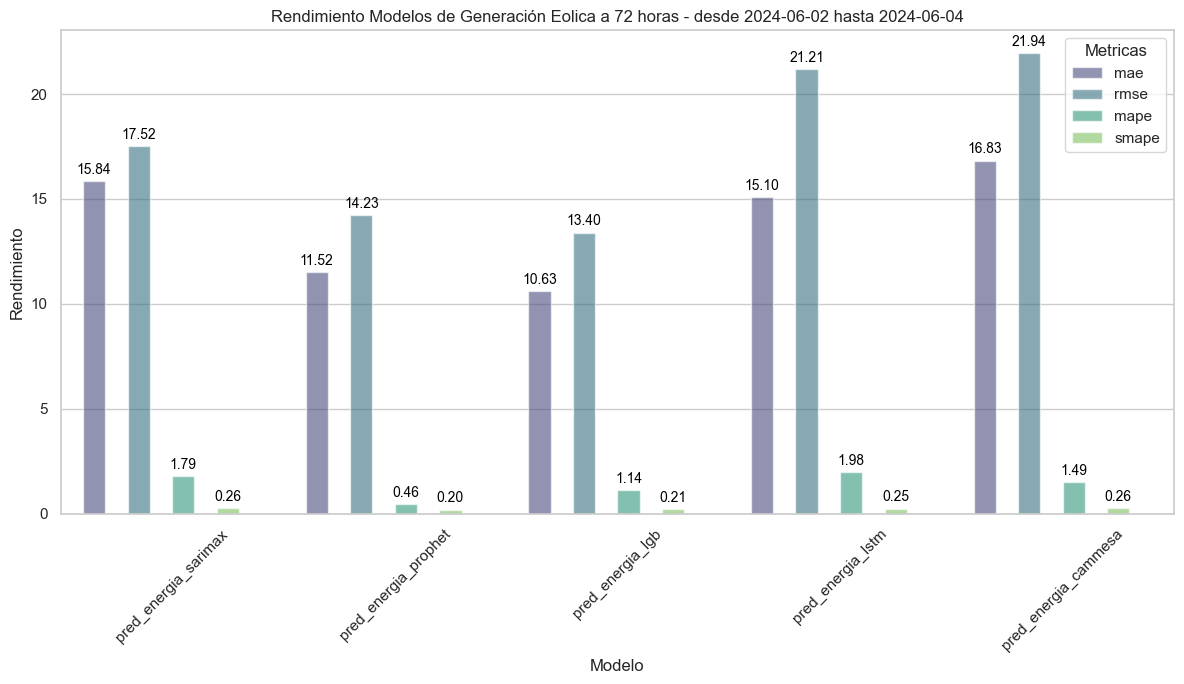

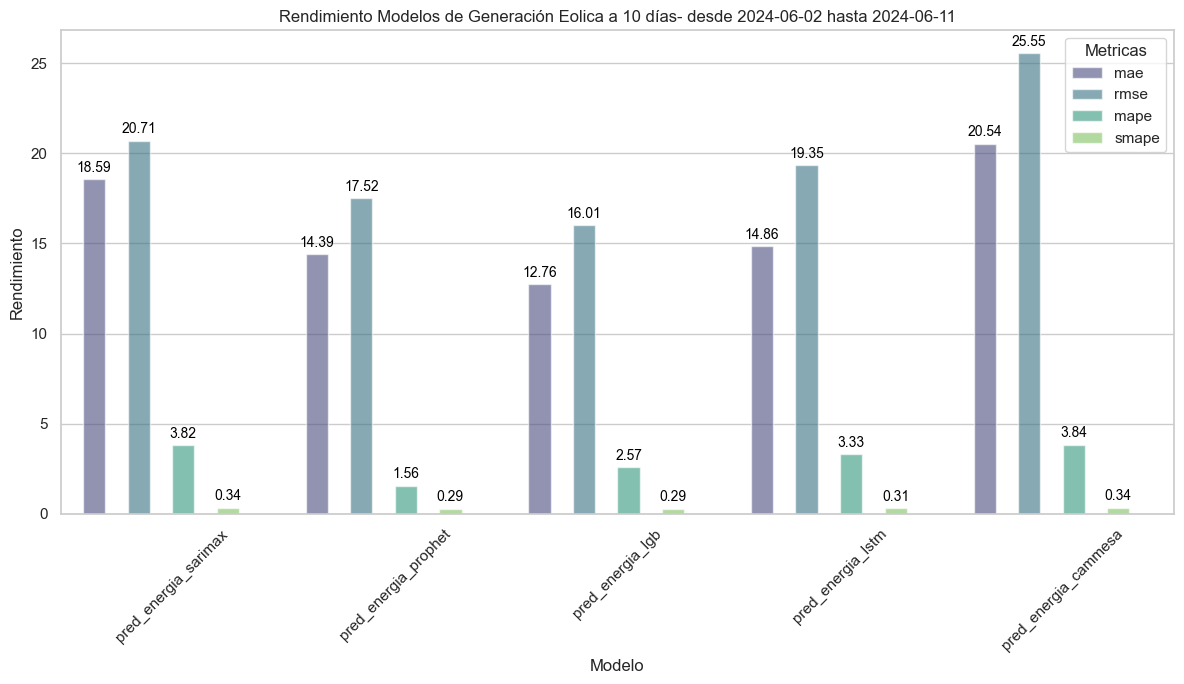

In [136]:
# Function to create barplot
def plot_performance(data, title, xlabel, ylabel):
    sns.set_theme(style="whitegrid")

    # Create a figure
    plt.figure(figsize=(12, 7))  # Width x Height

    # Draw a nested barplot
    g = sns.barplot(
        data=data,
        x="model", y="value", hue="metric",
        palette="viridis", alpha=.6
    )

    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)

    # Adjust legend
    plt.legend(title="Metricas")

    # Adjust the bar width
    bar_width = 0.1  # Set the desired bar width

    # Annotate each bar
    for bar in g.patches:
        bar.set_width(bar_width)
        height = bar.get_height()
        if height > 0.01:  # Skip very small values to avoid clutter
            g.annotate(f'{height:.2f}', 
                       (bar.get_x() + bar.get_width() / 2, height),
                       ha='center', va='bottom',
                       fontsize=10, color='black', xytext=(0, 3),
                       textcoords='offset points')

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
    plt.show()


title_72h = f"Rendimiento Modelos de Generación Eolica a 72 horas - desde {start_date_72h.date()} hasta {end_date_72h.date()}"

title_10d = f"Rendimiento Modelos de Generación Eolica a 10 días- desde {start_date_10d.date()} hasta {end_date_10d.date()}"

# Plot for df_results72h
plot_performance(df_results72h, title_72h , "Modelo", "Rendimiento")

# Plot for df_results10d
plot_performance(df_results10d, title_10d , "Modelo", "Rendimiento")



#### Correlacion de resultados de modelos

<Axes: >

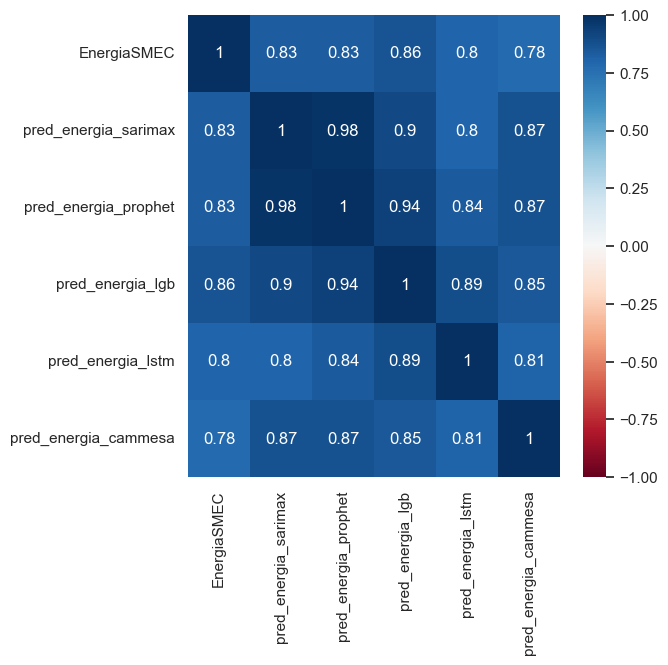

In [137]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','pred_energia_sarimax','pred_energia_prophet','pred_energia_lgb','pred_energia_lstm','pred_energia_cammesa']

plt.figure(figsize=(6,6))
sns.heatmap(df_fc_actual_merged[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

#### Grafico de la real vs prediccion a 10 dias

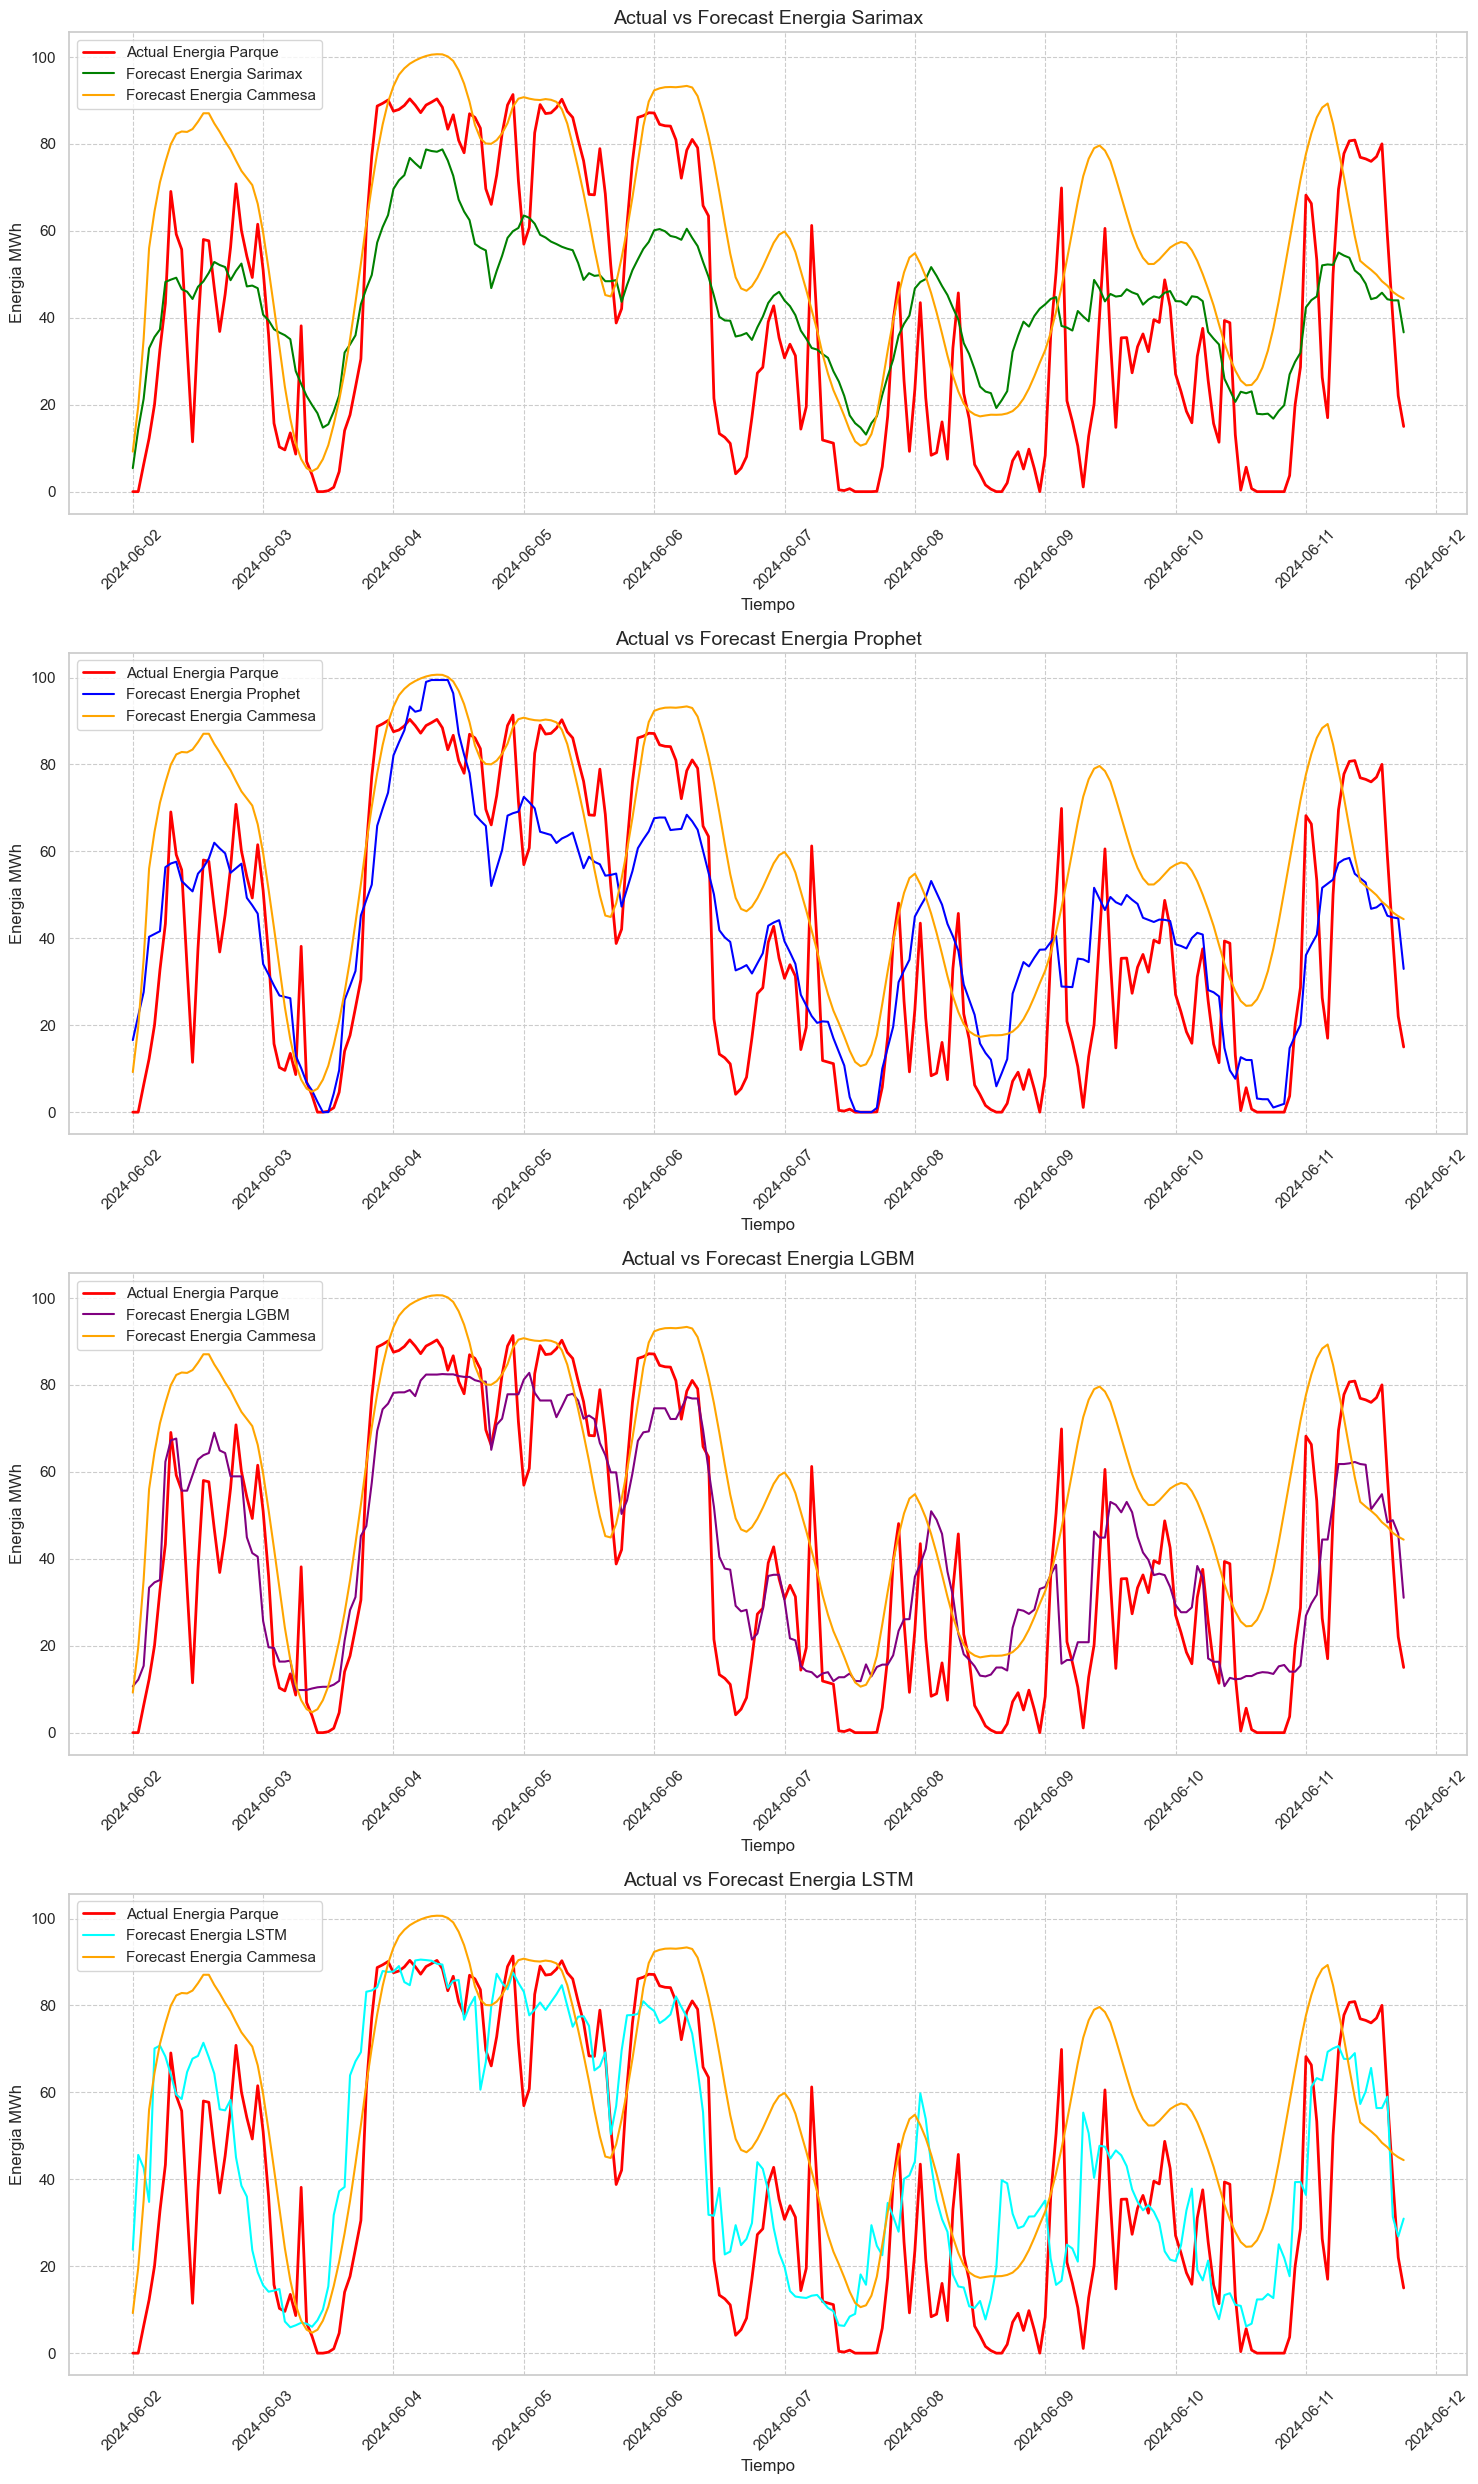

In [138]:

# Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))  # 4 rows, 1 column, increased height to 12 inches

# Plotting the 1 subplot
axes[0].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['EnergiaSMEC'], label='Actual Energia Parque', color='red', linewidth=2)
axes[0].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['pred_energia_sarimax'], label='Forecast Energia Sarimax', color='green', linewidth=1.5)
axes[0].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['pred_energia_cammesa'], label='Forecast Energia Cammesa', color='orange', linewidth=1.5)
axes[0].set_title('Actual vs Forecast Energia Sarimax', fontsize=14)
axes[0].set_xlabel('Tiempo', fontsize=12)
axes[0].set_ylabel('Energia MWh', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, linestyle='--', linewidth=0.8)
axes[0].tick_params(axis='x', rotation=45)

# Plotting the 2 subplot
axes[1].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['EnergiaSMEC'], label='Actual Energia Parque', color='red', linewidth=2)
axes[1].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['pred_energia_prophet'], label='Forecast Energia Prophet', color='blue', linewidth=1.5)
axes[1].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['pred_energia_cammesa'], label='Forecast Energia Cammesa', color='orange', linewidth=1.5)
axes[1].set_title('Actual vs Forecast Energia Prophet', fontsize=14)
axes[1].set_xlabel('Tiempo', fontsize=12)
axes[1].set_ylabel('Energia MWh', fontsize=12)
axes[1].legend(loc='best')
axes[1].grid(True, linestyle='--', linewidth=0.8)
axes[1].tick_params(axis='x', rotation=45)

# Plotting the 3 subplot
axes[2].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['EnergiaSMEC'], label='Actual Energia Parque', color='red', linewidth=2)
axes[2].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['pred_energia_lgb'], label='Forecast Energia LGBM', color='purple', linewidth=1.5)
axes[2].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['pred_energia_cammesa'], label='Forecast Energia Cammesa', color='orange', linewidth=1.5)
axes[2].set_title('Actual vs Forecast Energia LGBM', fontsize=14)
axes[2].set_xlabel('Tiempo', fontsize=12)
axes[2].set_ylabel('Energia MWh', fontsize=12)
axes[2].legend(loc='best')
axes[2].grid(True, linestyle='--', linewidth=0.8)
axes[2].tick_params(axis='x', rotation=45)

# Plotting the 4 subplot
axes[3].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['EnergiaSMEC'], label='Actual Energia Parque', color='red', linewidth=2)
axes[3].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['pred_energia_lstm'], label='Forecast Energia LSTM', color='cyan', linewidth=1.5)
axes[3].plot(df_fc_actual_merged['FechaHora'], df_fc_actual_merged['pred_energia_cammesa'], label='Forecast Energia Cammesa', color='orange', linewidth=1.5)
axes[3].set_title('Actual vs Forecast Energia LSTM', fontsize=14)
axes[3].set_xlabel('Tiempo', fontsize=12)
axes[3].set_ylabel('Energia MWh', fontsize=12)
axes[3].legend(loc='best')
axes[3].grid(True, linestyle='--', linewidth=0.8)
axes[3].tick_params(axis='x', rotation=45)




# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()